In [82]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import helper
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score

In [118]:
profiles = pd.read_json('data/profile.json',orient='records',lines=True)
transcripts = pd.read_json('data/transcript.json',orient='records',lines=True)
promotions = pd.read_json('data/portfolio.json',orient='records',lines=True)
#offer_variations = pd.read_csv('data/offer_variations.csv')

In [119]:
 trans_dt, trans_clean_dt = helper.transaction_preprocessing(profiles,transcripts,promotions)

File load from local directory as it was already available


In [120]:
print('shape of trans_dt:',trans_dt.shape)
print('shape of trans_clean_dt:',trans_clean_dt.shape)

shape of trans_dt: (306534, 19)
shape of trans_clean_dt: (297105, 19)


In [121]:
final_df = helper.feature_engineering(trans_dt,trans_clean_dt, profiles, promotions)

## 1. EDA:

### 1.1 Missing Values: 

Text(0.5, 1.0, 'Missing Counts Per Column')

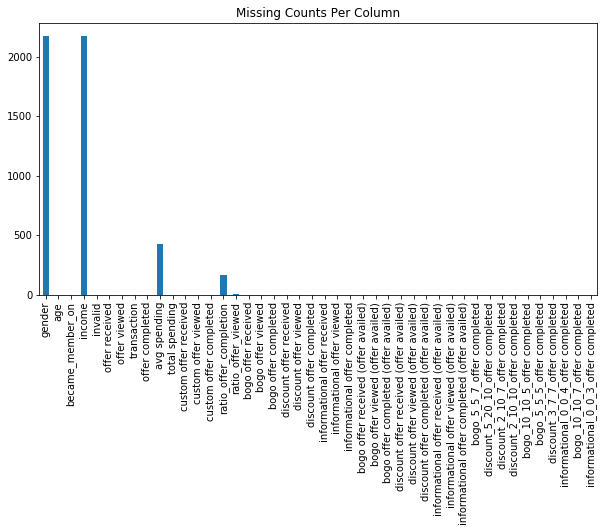

In [122]:
fig, ax = plt.subplots(figsize=(10,5))
final_df.isnull().sum().plot(kind='bar')
ax.set_title('Missing Counts Per Column')

## 2. Preprocessing

### 2.1 Missing Values:

In [123]:
(final_df.isnull().sum()/len(final_df))*100

gender                                           12.794118
age                                               0.000000
became_member_on                                  0.000000
income                                           12.794118
invalid                                           0.000000
offer received                                    0.000000
offer viewed                                      0.000000
transaction                                       0.000000
offer completed                                   0.000000
avg spending                                      2.482353
total spending                                    0.000000
custom offer received                             0.000000
custom offer viewed                               0.000000
custom offer completed                            0.000000
ratio_offer_completion                            0.976471
ratio_offer_viewed                                0.035294
bogo offer received                               0.0000

In [124]:
## Fill out data with mean and mode (naive approach)
def fill_data(df,columns):
    """
    fill data based on mean (continuous) and mode (categorical)
    """
    for col in columns:
        if col == 'gender':
            mode = df.gender.mode()[0]
            df['gender'] = df['gender'].fillna(mode)
        else:
            if col in ['ratio_offer_completion','ratio_offer_viewed']:
                median = final_df[col].median()
                df[col] = df[col].fillna(median)
            else:
                mean = df[col].mean()
                df[col] = df[col].fillna(mean)
    return df

In [125]:
mis_cols = final_df.columns[final_df.isnull().sum() >0 ].tolist()
mis_cols

['gender',
 'income',
 'avg spending',
 'ratio_offer_completion',
 'ratio_offer_viewed']

In [126]:
final_df = fill_data(final_df,mis_cols)

In [127]:
final_df.isnull().sum()

gender                                           0
age                                              0
became_member_on                                 0
income                                           0
invalid                                          0
offer received                                   0
offer viewed                                     0
transaction                                      0
offer completed                                  0
avg spending                                     0
total spending                                   0
custom offer received                            0
custom offer viewed                              0
custom offer completed                           0
ratio_offer_completion                           0
ratio_offer_viewed                               0
bogo offer received                              0
bogo offer viewed                                0
bogo offer completed                             0
discount offer received        

### 2.2 Associations and Correlations 

- How different males from female on based on offer completion and offer viewed rate? 

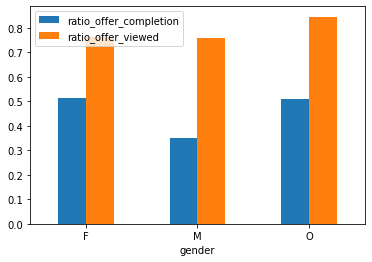

In [128]:
agg = final_df.groupby(by=['gender'])['ratio_offer_completion','ratio_offer_viewed'].mean().plot(kind='bar',rot=0)

<b style="color:red;" > Observation: </b>
__females__ and __Others__ have on average high tendency to view and complete the offer. (gender can be create distinction). 

- How different female are from male based on spending, age and income? 

Text(0.5, 1.0, 'income by gender')

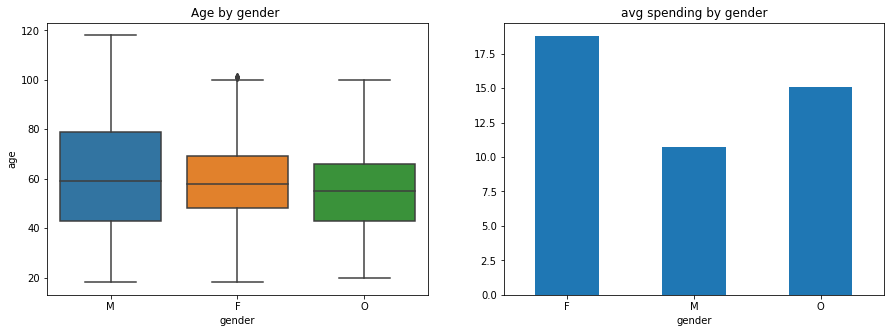

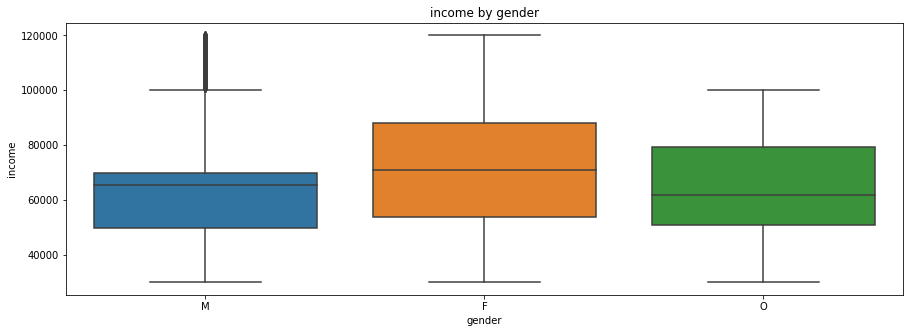

In [16]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))
sns.boxplot(final_df['gender'], final_df['age'], ax=ax[0])
ax[0].set_title('Age by gender ')
final_df.groupby(by=['gender'])['avg spending'].mean().plot(kind='bar',rot=0, ax=ax[1],title="avg spending by gender")
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y = final_df['income'], x=final_df['gender'])
ax.set_title('income by gender')

<b style="color:red;"> Observation: </b>
- Female on average earn more than male and others probably that's why they have high avg spending compared with rest of the gender in addition on average males and females have same age.  
- Others on average have low income than male and female but their avg spending is second highest next to female. 
- It seems like income, gender, avg spending and age can create distinction between clusters. 

- Just because male are older than females is this the only reason why they spending less on average? let's see. 

In [17]:
final_df = final_df.assign(age_bucket=pd.cut(final_df['age'],5))

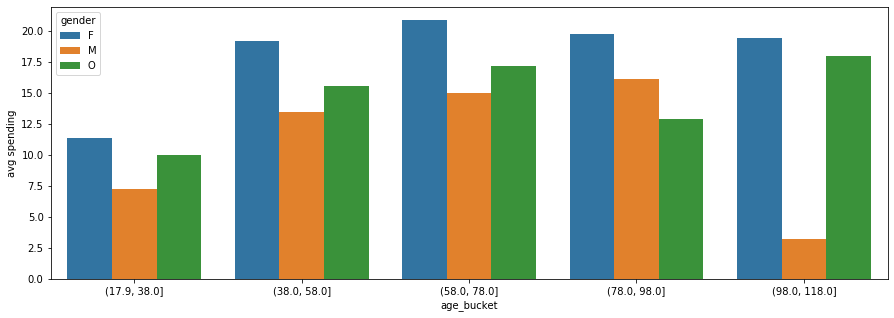

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
agg = final_df.groupby(by=['age_bucket','gender'])['avg spending'].mean().reset_index()
sns.barplot(x='age_bucket',y='avg spending',hue='gender',data=agg, ci=False)

<b style="color:red;"> Observation: </b>
- It is not the case as male in all age bucket except 78-98 have fairly low avg spending compared to rest of the genders. The low avg spending in males is not due to they are older. 

- Are males regular customers and females seasonal? 

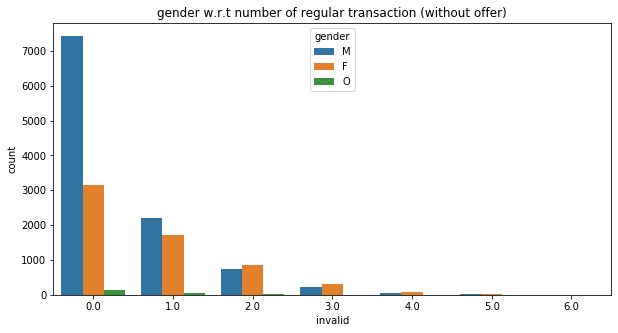

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(final_df['invalid'],hue=final_df['gender'])
ax.set_title('gender w.r.t number of regular transaction (without offer)')
plt.show()

In [20]:
females = final_df[final_df['gender']=='F']
(females.groupby(by=['invalid']).size()/females.shape[0])*100

invalid
0.0    51.623430
1.0    27.851199
2.0    13.982705
3.0     5.123185
4.0     1.240007
5.0     0.179475
dtype: float64

In [21]:
males = final_df[final_df['gender']=='M']
(males.groupby(by=['invalid']).size()/males.shape[0])*100

invalid
0.0    69.706351
1.0    20.555399
2.0     6.876818
3.0     2.204710
4.0     0.506614
5.0     0.140726
6.0     0.009382
dtype: float64

<b style="color:red;"> Observation: </b>
- Females have more regular transactions than males although females have high offer completion ratio than male (in first visualization of this notebook). It seems like there is some division within females such that one segments goes for offer and one segment goes for regular transaction. 
- In about 70% of the males avail offers.

- What are the distinct characteristics of females who opt for regular transaction than those who go to offers? 

In [22]:
females = final_df[(final_df['gender'] == 'F')]

In [23]:
females = females.assign(invalid_l2 = females['invalid'].apply(lambda x: 1 if x > 0 else 0))

In [24]:
female_reg = females[females['invalid_l2']==0]
female_sea = females[females['invalid_l2']==1]

In [25]:
print('regular customers (female) :', len(female_reg),'\nseasonal customers (female) :', len(female_sea) )

regular customers (female) : 3164 
seasonal customers (female) : 2965


1. Age

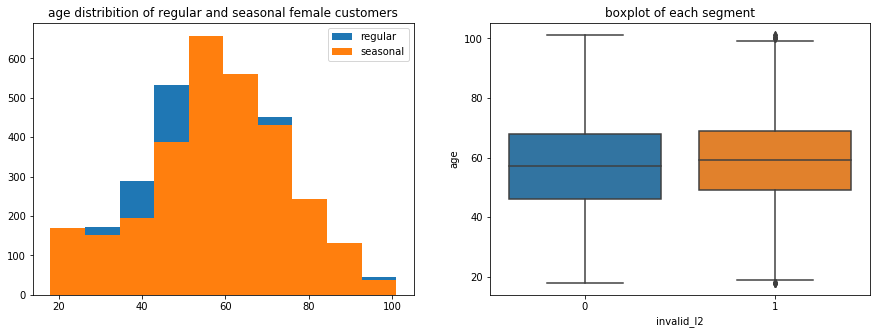

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].hist(female_reg['age'])
ax[0].hist(female_sea['age'])
ax[0].set_title('age distribition of regular and seasonal female customers')
ax[0].legend(['regular','seasonal'])
sns.boxplot(y=females['age'],x=females['invalid_l2'],ax=ax[1])
ax[1].set_title('boxplot of each segment')
plt.show()

In [27]:
females.groupby(by=['invalid_l2'])['age'].describe()

,count,mean,std,min,25%,50%,75%,max
invalid_l2,,,,,,,,
0,3164.0,56.985145,16.837381,18.0,46.0,57.0,68.0,101.0
1,2965.0,58.142327,16.914606,18.0,49.0,59.0,69.0,101.0


2. income and avg spending. 

In [28]:
females.groupby(by=['invalid_l2'])['income','avg spending'].agg(['mean','median','min','max','sum'])

income                                           \
                    mean   median      min       max          sum   
invalid_l2                                                          
0           68442.161820  67000.0  30000.0  120000.0  216551000.0   
1           74362.900506  74000.0  30000.0  120000.0  220486000.0   

           avg spending                                            
                   mean   median       min      max           sum  
invalid_l2                                                         
0             16.698112  15.6625  0.240000  451.470  52832.824830  
1             21.027813  19.8350  1.806154  291.315  62347.464308

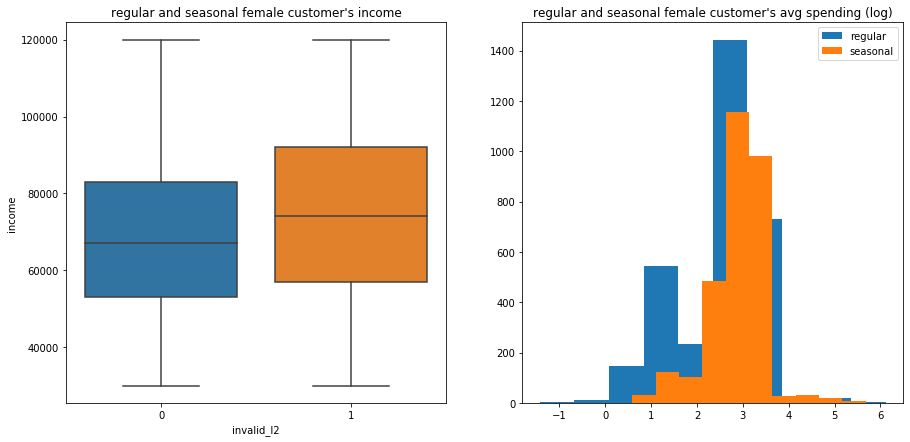

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
sns.boxplot(x='invalid_l2',y='income',data=females,ax=ax[0])
ax[0].set_title('regular and seasonal female customer\'s income')
plt.hist(np.log(female_reg['avg spending']))
plt.hist(np.log(female_sea['avg spending']))
ax[1].set_title('regular and seasonal female customer\'s avg spending (log)')
ax[1].legend(['regular','seasonal'])
plt.show()

3. offer completion and offer view rate. 

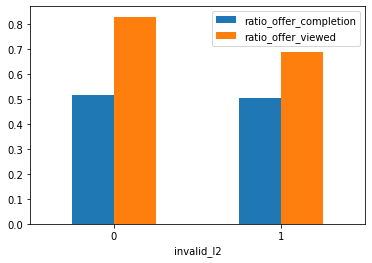

In [30]:
females.groupby(by=['invalid_l2'])['ratio_offer_completion','ratio_offer_viewed'].mean().plot(kind='bar',rot=0)

In [31]:
females.groupby(by=['invalid_l2'])['ratio_offer_completion','ratio_offer_viewed'].mean()

,ratio_offer_completion,ratio_offer_viewed
invalid_l2,,
0,0.514654,0.829867
1,0.505267,0.688252


4. member of starbucks since. 

In [16]:
def convert_into_dateformat(df, col):
    """
    Function to convert date into pandas datatime format. 
    
    Input: dataframe and column (contain date)
    Output: dataframe containing date (date time format)
    """
    # make a copy of dataframe #
    df = df.copy()
    # convert it into string #
    df[col] = df[col].astype(str)
    df[col] = pd.to_datetime(df[col])
    
    return df

In [33]:
females = convert_into_dateformat(females,'became_member_on')

In [34]:
# fetch year and month from member join date #
females = females.assign(member_year=pd.DatetimeIndex(females['became_member_on']).year)
females = females.assign(member_month=pd.DatetimeIndex(females['became_member_on']).month)
females = females.assign(member_days=pd.DatetimeIndex(females['became_member_on']).day)

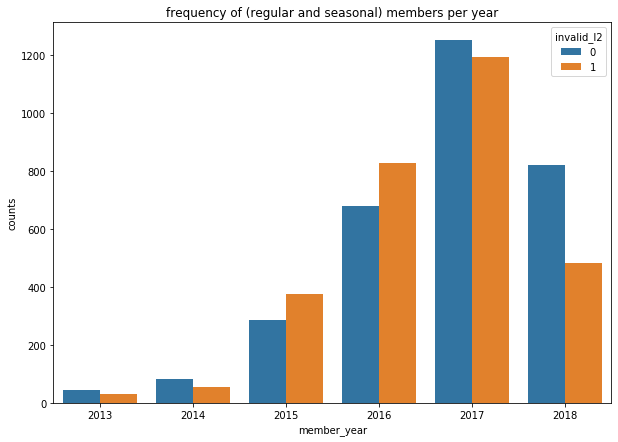

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
agg = females.groupby(by=['member_year','invalid_l2']).size().reset_index().rename(columns={0:'counts'})
sns.barplot(x='member_year',y='counts', hue='invalid_l2', data=agg, ci=False)
ax.set_title('frequency of (regular and seasonal) members per year')
plt.show()

5. custom offer complete and view:

In [36]:
females.groupby(by=['invalid_l2'])['custom offer completed','custom offer viewed'].median()

,custom offer completed,custom offer viewed
invalid_l2,,
0,2,4
1,2,3


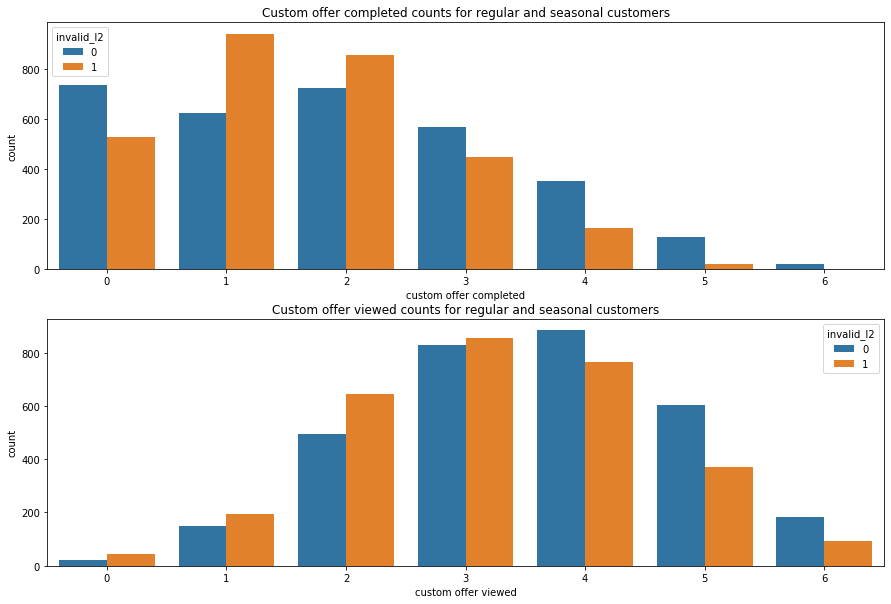

In [37]:
fig, ax = plt.subplots(nrows=2,figsize=(15,10))
sns.countplot(females['custom offer completed'],hue=females['invalid_l2'], ax =ax[0])
ax[0].set_title('Custom offer completed counts for regular and seasonal customers')

sns.countplot(females['custom offer viewed'],hue=females['invalid_l2'],ax=ax[1])
ax[1].set_title('Custom offer viewed counts for regular and seasonal customers')
plt.show()



6. no of transactions. 

In [340]:
def add_no_transactions(customers, trans_dt):
    """
    count total number of transaction by each customer 
    """
    customers = customers.copy()
    transactions_only = trans_dt[trans_dt['event']=='transaction']
    frequency = transactions_only.groupby(by=['person']).size()
    customers = customers.assign(total_transactions = frequency)
    return customers

In [39]:
females = add_no_transactions(females, trans_dt)

In [40]:
females.groupby(by=['invalid_l2'])['total_transactions'].describe()

,count,mean,std,min,25%,50%,75%,max
invalid_l2,,,,,,,,
0,3028.0,7.653236,4.622445,1.0,4.0,7.0,10.0,28.0
1,2965.0,8.839123,4.720968,1.0,5.0,8.0,12.0,31.0


7. Offer completed to no of transaction ratio. 

In [41]:
females['offer_trans_ratio'] = females['custom offer completed']/females['total_transactions']

In [42]:
females.groupby(by=['invalid_l2'])['offer_trans_ratio'].describe()*100

,count,mean,std,min,25%,50%,75%,max
invalid_l2,,,,,,,,
0,302800.0,30.308150,27.817289,0.0,11.111111,25.000000,42.857143,200.0
1,296500.0,20.669845,17.822224,0.0,9.090909,18.181818,28.571429,200.0


<b style="color:red;"> Explanation for regular and seasonal customers (female): </b>
- Age was quite the same between two segments of users. 
- Avg spending and income of seasonal customer is low than regular customers. 
- offer view rate was low in regular customers compared to seasonal customers but the offer completion rate was nearly same (though the completion rate depend on viewed and it was high in case of seasonal customer). 
- There were more transaction from regular customer than seasonal customers (as expected) and their offer completion to no of transaction ratio was also low (as expected) compared with seasonal customers. 

- How longer tenure relates to avg spending? Do loyal customers (having long tenure) spend more than new customer?  

In [43]:
final_df = convert_into_dateformat(final_df,'became_member_on')

In [44]:
# fetch year and month from member join date #
final_df = final_df.assign(member_year=pd.DatetimeIndex(final_df['became_member_on']).year)
final_df = final_df.assign(member_month=pd.DatetimeIndex(final_df['became_member_on']).month)
final_df = final_df.assign(member_days=pd.DatetimeIndex(final_df['became_member_on']).day)

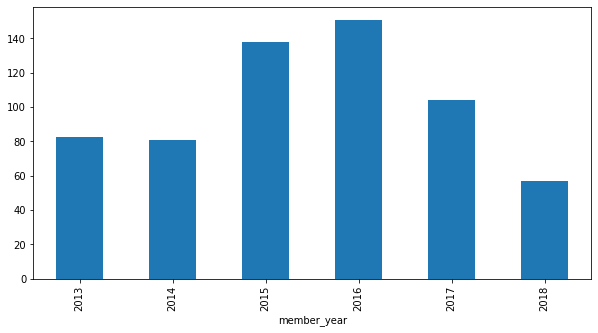

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
agg = final_df.groupby(by=['member_year'])['total spending'].mean().plot(kind='bar')

<b style="color:red;"> Observation: </b>
- tenure doesn't seem to play any role in increasing amount of transactions. 

- Number of bogo and discount offers availed by each gender. 

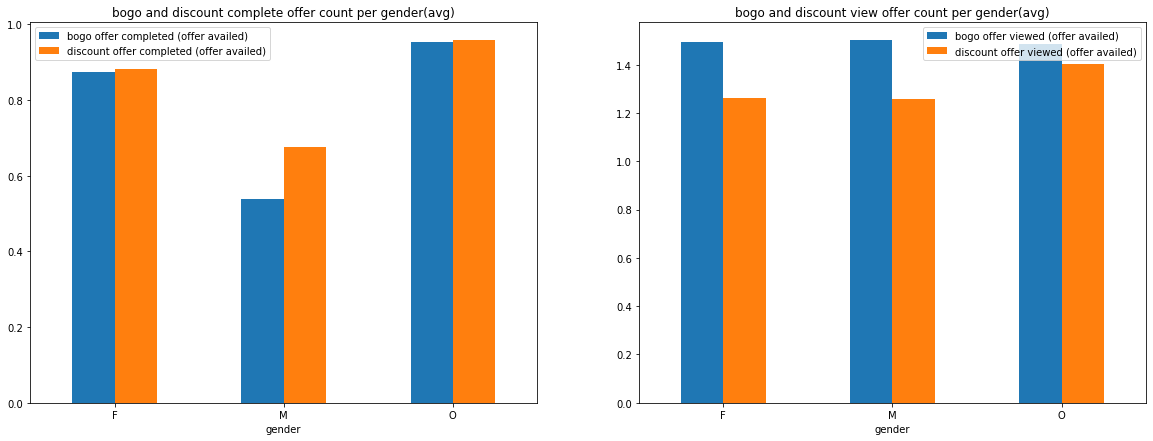

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(20,7))
final_df.groupby(by=['gender'])['bogo offer completed (offer availed)','discount offer completed (offer availed)'].mean().plot(kind='bar',rot=0,title="bogo and discount complete offer count per gender(avg)",ax=ax[0])
final_df.groupby(by=['gender'])['bogo offer viewed (offer availed)','discount offer viewed (offer availed)'].mean().plot(kind='bar',rot=0,title="bogo and discount view offer count per gender(avg)",ax=ax[1])

<b style="color:red;"> Observation: </b>
- Discount offer have high view rate in all genders but males have high tendency to go for discount then bogo whereas the completion rate of bogo and discount for the rest of the genders are roughly same. (bogo offer completed with gender can create a distinction). 

- Regular and Seasonal Customer

In [47]:
final_df = final_df.assign(cus_type=final_df['invalid'].apply(lambda x: 1 if x > 0 else 0))

- Number of transactions. 

In [48]:
final_df = add_no_transactions(final_df, trans_dt)

In [49]:
final_df.groupby(by=['cus_type'])['total_transactions'].describe()

,count,mean,std,min,25%,50%,75%,max
cus_type,,,,,,,,
0,10317.0,7.825821,4.929475,1.0,4.0,7.0,10.0,36.0
1,6261.0,9.297876,5.006951,1.0,5.0,8.0,12.0,36.0


- Offer complete to no. of transaction ratio. 

In [50]:
final_df = final_df.assign(offer_trans_ratio= final_df['custom offer completed']/final_df['total_transactions'])

### 2.3 One hot encoding for categorical features 

In [51]:
X = pd.get_dummies(final_df)
X 

,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,...,total_transactions,offer_trans_ratio,gender_F,gender_M,gender_O,"age_bucket_(17.9, 38.0]","age_bucket_(38.0, 58.0]","age_bucket_(58.0, 78.0]","age_bucket_(78.0, 98.0]","age_bucket_(98.0, 118.0]"
id,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,118,2017-02-12,65404.991568,0.0,5.0,5.0,9.0,2.0,2.266667,20.40,...,9.0,0.222222,0,1,0,0,0,0,0,1
0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,112000.000000,1.0,2.0,0.0,3.0,1.0,25.670000,77.01,...,3.0,0.000000,1,0,0,0,1,0,0,0
38fe809add3b4fcf9315a9694bb96ff5,118,2018-07-12,65404.991568,0.0,2.0,2.0,6.0,0.0,2.383333,14.30,...,6.0,0.000000,0,1,0,0,0,0,0,1
78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,100000.000000,1.0,4.0,4.0,7.0,3.0,22.752857,159.27,...,7.0,0.285714,1,0,0,0,0,1,0,0
a03223e636434f42ac4c3df47e8bac43,118,2017-08-04,65404.991568,0.0,5.0,3.0,3.0,0.0,1.550000,4.65,...,3.0,0.000000,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,45,2018-06-04,54000.000000,0.0,3.0,3.0,7.0,0.0,2.861429,20.03,...,7.0,0.000000,1,0,0,0,1,0,0,0
2cb4f97358b841b9a9773a7aa05a9d77,61,2018-07-13,72000.000000,1.0,3.0,1.0,7.0,1.0,3.710000,25.97,...,7.0,0.000000,0,1,0,0,0,1,0,0
01d26f638c274aa0b965d24cefe3183f,49,2017-01-26,73000.000000,0.0,3.0,1.0,8.0,0.0,4.967500,39.74,...,8.0,0.000000,0,1,0,0,1,0,0,0


## 3. Clustering 

### 3.1 Clustering without any preprocessing (scaling and PCA)

In [16]:
from sklearn.decomposition import PCA

In [17]:
def pca_fit_transform(df, var = None):
    pca = PCA(var)
    transform_arr = pca.fit_transform(df)
    return pca, transform_arr


In [84]:
pca_main = PCA()
pca_main, pca_transform_main = pca_fit_transform(X, var=0.95)

TypeError: invalid type promotion

In [77]:
pca_transform_main

NameError: name 'pca_transform_main' is not defined

In [18]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')



Number of Main PCA components that explained at least 95% variance : 2


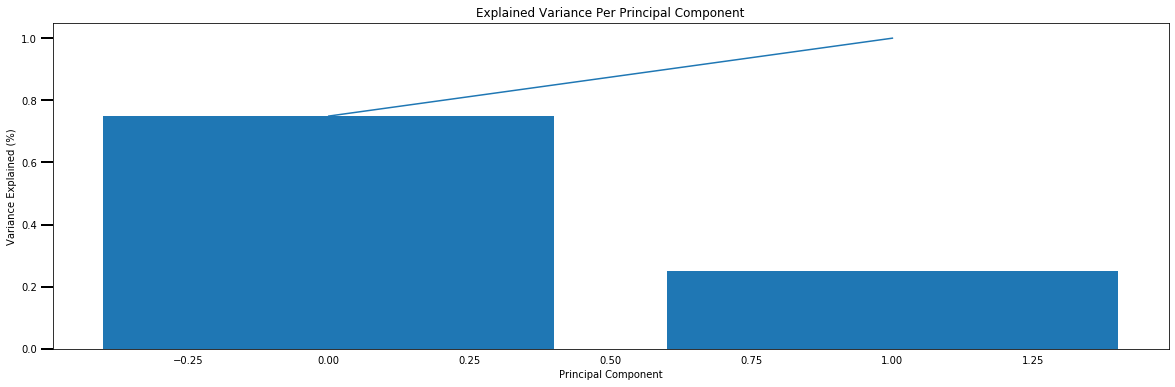

In [169]:
scree_plot(pca_main)

#PCA
# number of PCA components that explained at least 95% variance ==> 34 components
cumvals = np.cumsum(pca_main.explained_variance_ratio_)
print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

In [19]:
def plot_weight(df, pca, ith) :
    '''
    plot weight for the i-th principal component to corresponding feature names
    Input : 
        df = original dataframe
        pca = pca.fit(data)
        ith = int value, from 1 to len(pca.n_components)
    Return : axes of barplot 
    '''
    sort_pca = sorted([(weight, label) for weight,label in zip(pca.components_[ith-1], df.columns) ])
    weights, features = zip(*sort_pca)
    weights, features = list(weights), list(features)
    fig, ax = plt.subplots(figsize=(10,20))
    ax = sns.barplot(weights, features)
    return ax


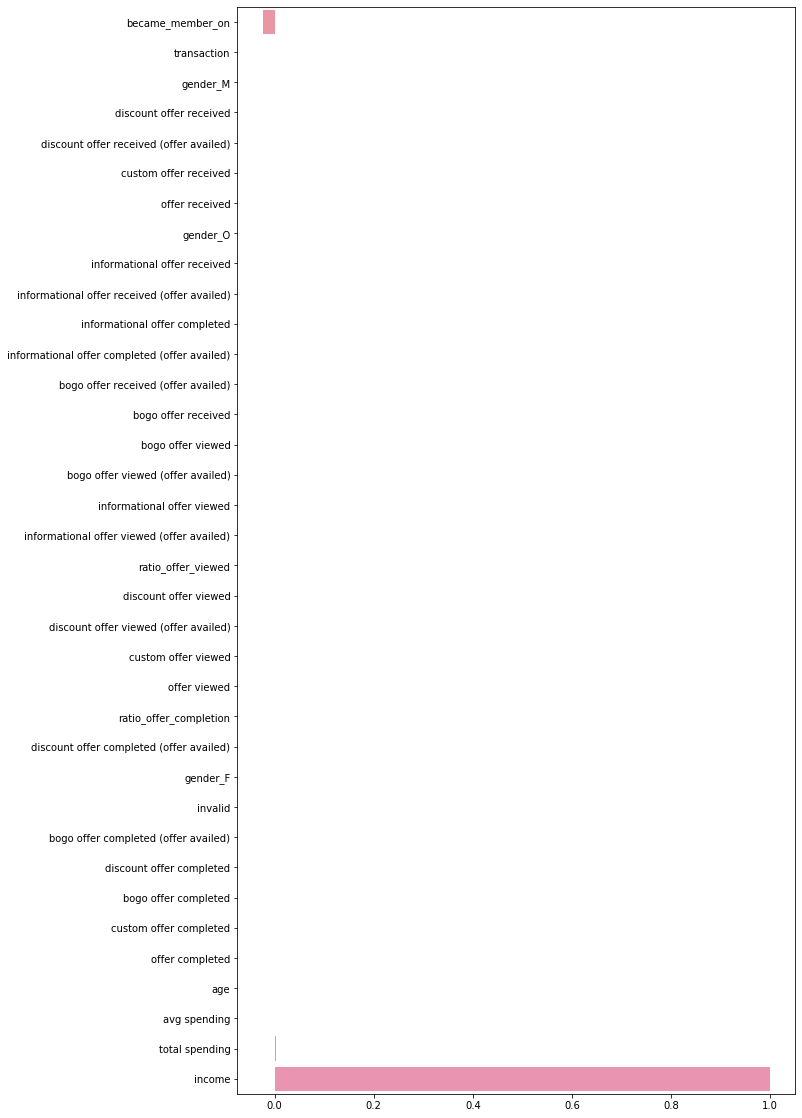

In [171]:
# 1st PCA comp
plot_weight(X,pca_main, 1 )

In [20]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score
from tqdm import tqdm

def finding_num_cluster(X, min_clusters =2, max_clusters =30):
    silh = []
    inertia = []
    clusters = range(min_clusters,max_clusters)
    for n in tqdm(clusters):

        model = KMeans(n_clusters = n, random_state=42)
        preds = model.fit_predict(X)

        silhouette_avg = silhouette_score(X, preds)

        silh.append(silhouette_avg)
        inertia.append(model.inertia_)

    fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
    ax1.plot(clusters, silh,marker="o")
    ax1.set_ylabel("Silhoutte Score")
    ax1.set_xlabel('number of clusters')
    ax2.plot(clusters, inertia, marker="o")
    ax2.set_ylabel("Inertia (SSE)")
    ax2.set_xlabel("number of clusters")
    plt.show()



100%|██████████| 28/28 [03:27<00:00,  7.42s/it]


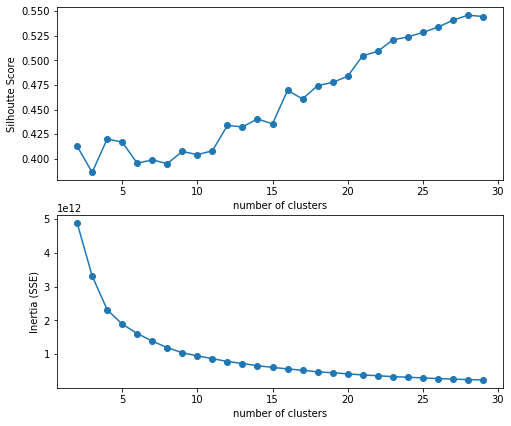

In [22]:
finding_num_cluster(pca_transform_main)

### 3.2 Clustering with preprocessing (Scaling)

In [21]:
final_df

,gender,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,...,bogo_5_5_7_offer completed,discount_5_20_10_offer completed,discount_2_10_7_offer completed,discount_2_10_10_offer completed,bogo_10_10_5_offer completed,bogo_5_5_5_offer completed,discount_3_7_7_offer completed,informational_0_0_4_offer completed,bogo_10_10_7_offer completed,informational_0_0_3_offer completed
68be06ca386d4c31939f3a4f0e3dd783,M,118,20170212,65404.991568,0.0,5.0,5.0,9.0,2.0,2.266667,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.000000,1.0,2.0,0.0,3.0,1.0,25.670000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38fe809add3b4fcf9315a9694bb96ff5,M,118,20180712,65404.991568,0.0,2.0,2.0,6.0,0.0,2.383333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.000000,1.0,4.0,4.0,7.0,3.0,22.752857,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
a03223e636434f42ac4c3df47e8bac43,M,118,20170804,65404.991568,0.0,5.0,3.0,3.0,0.0,1.550000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,20180604,54000.000000,0.0,3.0,3.0,7.0,0.0,2.861429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.000000,1.0,3.0,1.0,7.0,1.0,3.710000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01d26f638c274aa0b965d24cefe3183f,M,49,20170126,73000.000000,0.0,3.0,1.0,8.0,0.0,4.967500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9dc1421481194dcd9400aec7c9ae6366,F,83,20160307,50000.000000,2.0,3.0,3.0,14.0,3.0,13.547857,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [343]:
X = pd.get_dummies(final_df)

In [344]:
X['year'] = pd.DatetimeIndex(X['became_member_on']).year

In [345]:
final_df = add_no_transactions(final_df, trans_dt)

Standarize the complete and view counts (an offer can't complete without view this is what we are assuming here.)

In [213]:
X['bogo offer viewed (offer availed)'] = np.where(X['bogo offer completed (offer availed)'] > X['bogo offer viewed (offer availed)'], (X['bogo offer completed (offer availed)'] - X['bogo offer viewed (offer availed)'])+X['bogo offer viewed (offer availed)'],X['bogo offer viewed (offer availed)'])
X['discount offer viewed (offer availed)'] = np.where(X['discount offer completed (offer availed)'] > X['discount offer viewed (offer availed)'], (X['discount offer completed (offer availed)'] - X['discount offer viewed (offer availed)'])+X['discount offer viewed (offer availed)'],X['discount offer viewed (offer availed)'])

In [346]:
X['bogo_complete_rate'] = X['bogo offer completed (offer availed)']/X['bogo offer viewed (offer availed)']
X['discount_complete_rate'] = X['discount offer completed (offer availed)']/X['discount offer viewed (offer availed)']

In [347]:
X = X.assign(bogo_complete_rate = X['bogo offer completed (offer availed)']/X['bogo offer viewed (offer availed)'])
X = X.assign(discount_complete_rate= X['discount offer completed (offer availed)']/X['discount offer viewed (offer availed)'])

X = X.assign(bogo_view_rate= X['bogo offer viewed (offer availed)']/X['bogo offer received (offer availed)'])
X = X.assign(discount_view_rate= X['discount offer viewed (offer availed)']/X['discount offer received (offer availed)'])

In [348]:
X[['bogo_complete_rate','discount_complete_rate','bogo_view_rate','discount_view_rate']] = X[['bogo_complete_rate','discount_complete_rate','bogo_view_rate','discount_view_rate']].fillna(0)

In [354]:
X['total_transactions'] = X['total_transactions'].fillna(0)

In [355]:
X = X[['bogo_complete_rate','discount_complete_rate','income','total spending',
      'gender_F','gender_M','gender_O', 'age','total_transactions']]

In [356]:
X['bogo_complete_rate'] = np.square(X['bogo_complete_rate'])
X['discount_complete_rate'] = np.square(X['discount_complete_rate'])

In [357]:
from sklearn.preprocessing import StandardScaler

def perform_scaling(df):
    scaler = StandardScaler()
    std_arr = scaler.fit_transform(df)
    df_std = pd.DataFrame(std_arr, index=df.index, columns= df.columns)
    return df_std, scaler


In [358]:
profile_std_main, scaler_main = perform_scaling(X)

In [359]:
pca_main, pca_transform_main = pca_fit_transform(profile_std_main, var=0.95)

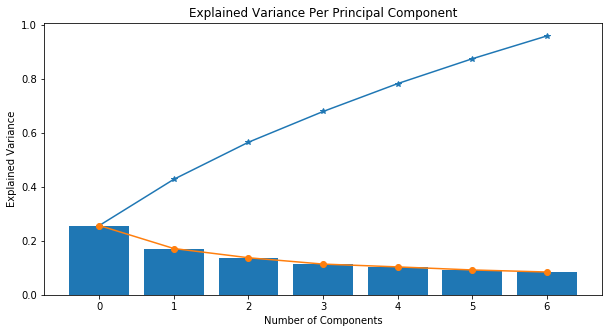

Number of Main PCA components that explained at least 95% variance : 7


In [360]:
scree_plot(pca_main)

#PCA
# number of PCA components that explained at least 95% variance ==> 34 components
cumvals = np.cumsum(pca_main.explained_variance_ratio_)
print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

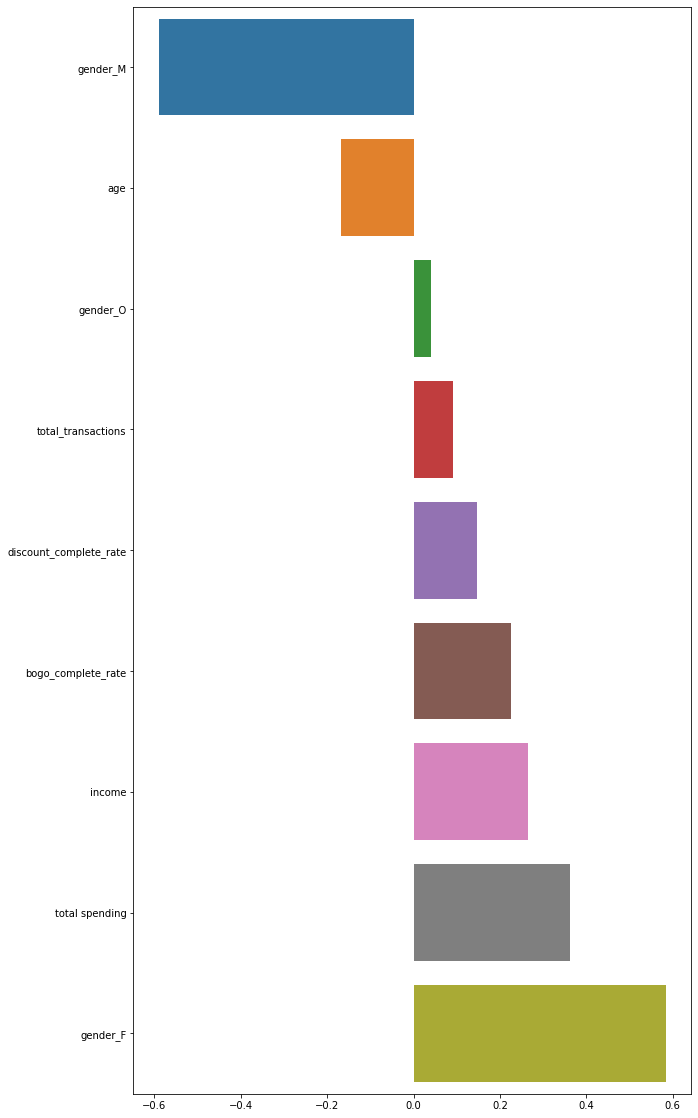

In [361]:
# 1st PCA comp
plot_weight(X,pca_main, 1 )

In [362]:
len(pca_main.components_)

7

### 3.3 Clustering with my function 

In [363]:
## Scale and initialize PCA #

In [364]:
def scree_plot(pca):
    """
    draw a scree plot to determine the optimal components for pca 
    """
    # total number of components #
    num_components = len(pca.explained_variance_ratio_)
    # create array (size == number of components)
    components = np.arange(num_components)
    # variance of each component # 
    variance = np.array(pca.explained_variance_ratio_)
    # cumulative sum of variance #
    cum_variance = np.cumsum(variance)
    
    # time for plotting #
    plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    ax.bar(components, variance)
    ax.plot(components, cum_variance, marker="*")
    ax.plot(components, variance, marker="o")
    ax.set_title('Explained Variance Per Principal Component')
    ax.set_ylabel('Explained Variance')
    ax.set_xlabel('Number of Components')
    plt.show()
    

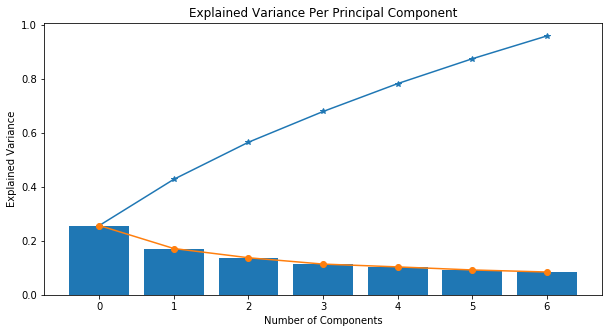

In [365]:
scree_plot(pca_main)

In [366]:
def evaluation_metric(features, min_cluster=2, max_cluster=20):
    """
    Determine the appropriate number of clusters based on different  
    standard metric such as inertia and silohutte
    """
    silhouette = []
    inertia = []
    clusters = range(min_cluster, max_cluster)
    for cluster in tqdm(clusters):
        K_means = KMeans(n_clusters = cluster)
        preds = K_means.fit_predict(features)
        silhouette.append(silhouette_score(features, preds))
        inertia.append(K_means.inertia_)
    metrics = [silhouette, inertia]
    titles = ['Silhouette score Per Cluster','Inertia (SSE) Per Cluster']
    y_labels = ['Silhouette score','Inertia (SSE)']
    # time for plotting #
    fig, axes = plt.subplots(nrows=2,figsize=(10,10))
    for ax,y,title,ylabel in zip(axes,metrics,titles,y_labels):
        ax.plot(clusters, y, marker='o')
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xticks([i for i in range(min_cluster,max_cluster)])
        ax.set_xlabel('Number of Clusters')
        
        
        

100%|██████████| 14/14 [01:15<00:00,  5.39s/it]


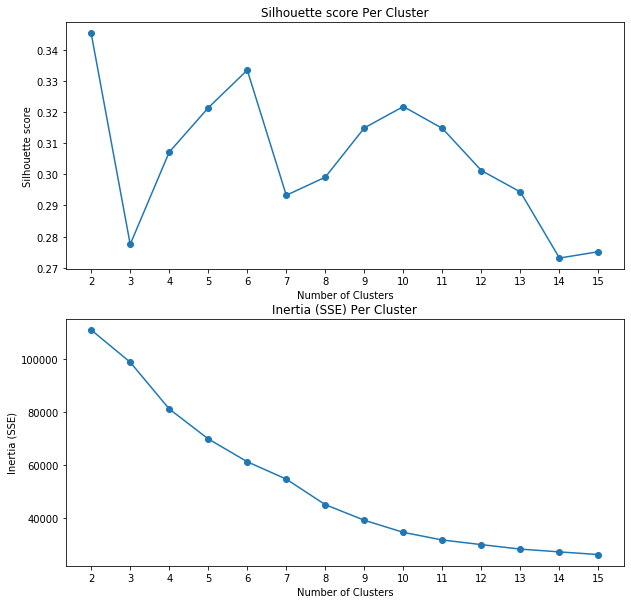

In [367]:
evaluation_metric(pca_transform_main, max_cluster=16)

100%|██████████| 28/28 [02:54<00:00,  6.23s/it]


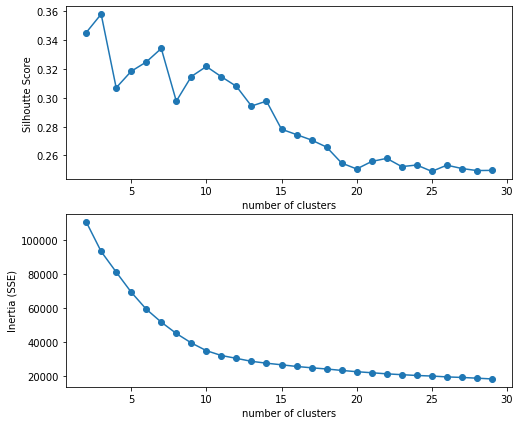

In [368]:
finding_num_cluster(pca_transform_main)

In [282]:
### 3.4 Finally perform Kmean clustering (with 15 clusters)
k_means = KMeans(n_clusters=14)
preds_cluster = k_means.fit_predict(pca_transform_main)

In [369]:
final_df['Cluster'] = preds_cluster

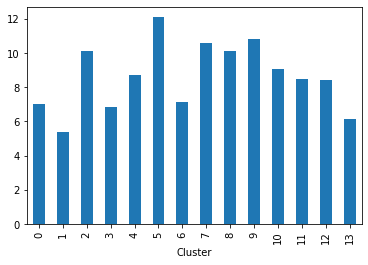

In [373]:
final_df.groupby(by=['Cluster'])['total_transactions'].mean().plot(kind='bar')

## 4. Visualizing Clusters & Making Sense of it: 

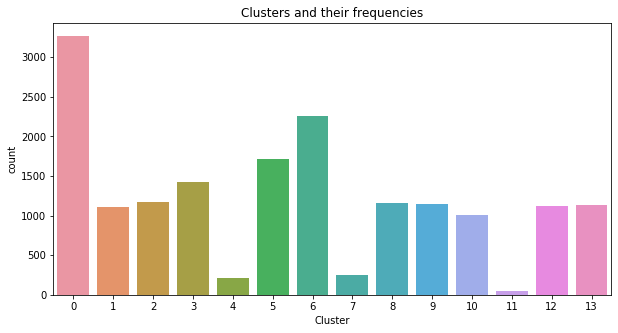

In [284]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(final_df['Cluster'])
ax.set_title('Clusters and their frequencies')
plt.show()

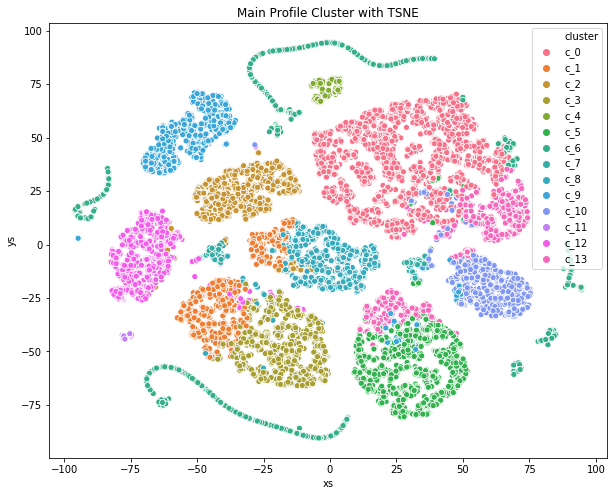

In [285]:
""" Visualise Cluster with TSNE"""
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42).fit_transform(pca_transform_main)
tsne_df = pd.DataFrame(tsne, columns=['xs', 'ys'])
tsne_df['cluster'] = ['c_' + str(i) for i in preds_cluster]

#plot tsne
f,ax = plt.subplots(figsize=(10,8))
sns.scatterplot('xs','ys', hue='cluster', data=tsne_df, ax=ax, hue_order=['c_' + str(i) for i in range(0,14)])
ax.set_title("Main Profile Cluster with TSNE")
#save fig
f.savefig('main_tsne.png', dpi = 300)

In [286]:
""" Cluster Centroid """

def inverse_transform_centroid(df, kmeans, pca, scaler):
    """ 
    INPUT : 
        df : dataframe
        kmeans : sklearn object of fitted KMeeans
        pca : sklearn object of fitted PCA
        scaler : sklearn object of fitted Scaler
    RETUNR :
        centers : dataframe of center value each cluster
    """
    centers = kmeans.cluster_centers_
    centers_pca = pca.inverse_transform(centers)
    centers = scaler.inverse_transform(centers_pca)
    centers = pd.DataFrame(centers, columns= df.columns)
    return centers

In [287]:
pd.set_option('display.max_columns', 500)
profile_main = final_df.copy()
profile_main_centroid = inverse_transform_centroid(X, k_means, pca_main, scaler_main)
profile_main_centroid

,bogo_complete_rate,discount_complete_rate,income,total spending,gender_F,gender_M,gender_O,age
0,0.037881,0.036941,51100.704010,34.396094,-5.939693e-15,1.000000e+00,-2.949030e-17,47.596878
1,0.088481,0.362341,96843.012704,126.177205,1.000000e+00,2.442491e-15,-1.700029e-16,64.829401
2,1.008357,1.000432,73977.040816,186.712679,1.000000e+00,1.332268e-15,1.162265e-16,58.573980
3,0.063884,0.047885,55108.222066,55.300422,1.000000e+00,-1.332268e-15,2.428613e-17,53.000703
4,0.463187,0.527619,63287.735849,124.323302,3.164136e-15,1.110223e-16,1.000000e+00,54.400943
5,0.066353,0.999284,53148.774796,85.728810,-2.609024e-15,1.000000e+00,8.673617e-17,48.896733
6,0.050038,0.139710,65192.361310,19.067174,-6.050715e-15,1.000000e+00,-1.040834e-16,116.612046
7,0.586791,0.570485,78380.566802,818.914332,5.060729e-01,4.939271e-01,2.775558e-17,57.000000
8,0.084751,0.997780,60787.307033,129.483087,1.000000e+00,-1.332268e-15,0.000000e+00,54.583190
9,0.984132,1.004813,68529.034940,174.479158,1.409983e-14,1.000000e+00,4.163336e-17,56.269298


In [288]:
X['Cluster'] = preds_cluster

In [296]:
X['bogo_complete_rate'] = np.sqrt(X['bogo_complete_rate'])
X['discount_complete_rate'] = np.sqrt(X['discount_complete_rate'])

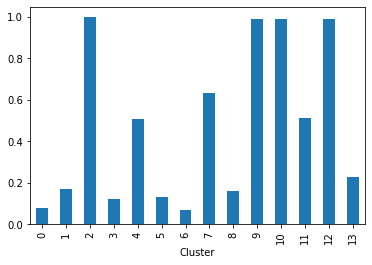

In [297]:
agg = X.groupby(by=['Cluster'])['bogo_complete_rate'].mean().plot(kind='bar')

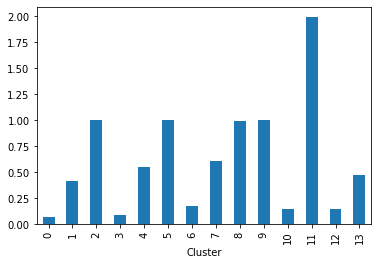

In [298]:
agg = X.groupby(by=['Cluster'])['discount_complete_rate'].mean().plot(kind='bar')

# Cluster Analysis:

1. Cluster # 01 : Prefer discount than bogo. 

In [336]:
cluster_01 = final_df[(final_df['Cluster']==1) & (final_df['invalid']==0)]

In [338]:
cluster_01 

,gender,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed,bogo offer received,bogo offer viewed,bogo offer completed,discount offer received,discount offer viewed,discount offer completed,informational offer received,informational offer viewed,informational offer completed,bogo offer received (offer availed),bogo offer viewed (offer availed),bogo offer completed (offer availed),discount offer received (offer availed),discount offer viewed (offer availed),discount offer completed (offer availed),informational offer received (offer availed),informational offer viewed (offer availed),informational offer completed (offer availed),bogo_5_5_7_offer completed,discount_5_20_10_offer completed,discount_2_10_7_offer completed,discount_2_10_10_offer completed,bogo_10_10_5_offer completed,bogo_5_5_5_offer completed,discount_3_7_7_offer completed,informational_0_0_4_offer completed,bogo_10_10_7_offer completed,informational_0_0_3_offer completed,age_bucket,member_year,member_month,member_days,cus_type,total_transactions,offer_trans_ratio,Cluster
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ebe7ef46ea6f4963a7dd49f501b26779,M,59,2015-01-21,41000.0,0.0,6.0,5.0,13.0,2.0,4.006154,52.08,6,5,2,0.400000,0.833333,2.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(58.0, 78.0]",2015,1,21,0,13.0,0.153846,1
c0d210398dee4a0895b24444a5fcd1d2,M,45,2018-07-07,33000.0,0.0,5.0,5.0,8.0,3.0,7.656250,61.25,5,5,3,0.600000,1.000000,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,"(38.0, 58.0]",2018,7,7,0,8.0,0.375000,1
39dbcf43e24d41f4bbf0f134157e0e1e,M,76,2014-08-31,64000.0,0.0,3.0,2.0,8.0,1.0,13.865000,110.92,3,2,1,0.500000,0.666667,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(58.0, 78.0]",2014,8,31,0,8.0,0.125000,1
6e04a90a0e074496b5f229eb1f553433,M,27,2018-01-10,35000.0,0.0,5.0,4.0,12.0,1.0,2.463333,29.56,5,4,1,0.250000,0.800000,1.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(17.9, 38.0]",2018,1,10,0,12.0,0.083333,1
0ba6e2ad781c4429afd26cf0b35f2d11,M,73,2018-04-01,51000.0,0.0,5.0,4.0,9.0,1.0,2.603333,23.43,5,4,1,0.250000,0.800000,1.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(58.0, 78.0]",2018,4,1,0,9.0,0.111111,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c46979c4562b459b8da06acd4be9ab77,M,27,2017-04-12,36000.0,0.0,6.0,3.0,17.0,2.0,3.280000,55.76,6,3,2,0.666667,0.500000,2.0,2.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,"(17.9, 38.0]",2017,4,12,0,17.0,0.117647,1
2ce987015ec0404a97ba333e8e814090,M,38,2013-08-08,61000.0,0.0,3.0,2.0,14.0,1.0,2.866429,40.13,3,2,1,0.500000,0.666667,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(17.9, 38.0]",2013,8,8,0,14.0,0.071429,1
52ddffcfe3b94288a958af3b48fdbcc1,M,36,2017-02-17,47000.0,0.0,4.0,3.0,17.0,1.0,2.910588,49.48,4,3,1,0.333333,0.750000,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(17.9, 38.0]",2017,2,17,0,17.0,0.058824,1


5.0

i. Is it mostly male cluster? 

In [339]:
cluster_01['gender'].value_counts()

M    1095
Name: gender, dtype: int64

ii. What is the income range within this cluster? 

In [340]:
cluster_01['income'].describe()

count     1095.000000
mean     52501.369863
std      13524.834897
min      30000.000000
25%      41000.000000
50%      53000.000000
75%      63000.000000
max      85000.000000
Name: income, dtype: float64

ii. What is spending distribution within this cluster? 

In [341]:
cluster_01['total spending'].describe()

count    1095.000000
mean       64.050941
std        50.857984
min         8.210000
25%        31.195000
50%        50.000000
75%        76.710000
max       472.410000
Name: total spending, dtype: float64

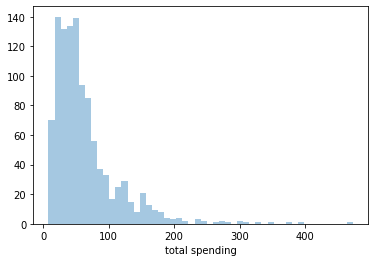

In [342]:
sns.distplot(cluster_01['total spending'], kde=False)

iii. Does customers in this cluster prefer discount because they didn't view bogo offers? 

In [343]:
cluster_01 = cluster_01.assign(bogo_complete_rate = cluster_01['bogo offer completed (offer availed)']/cluster_01['bogo offer viewed (offer availed)'])
cluster_01 = cluster_01.assign(discount_complete_rate= cluster_01['discount offer completed (offer availed)']/cluster_01['discount offer viewed (offer availed)'])

cluster_01 = cluster_01.assign(bogo_view_rate= cluster_01['bogo offer viewed (offer availed)']/cluster_01['bogo offer received (offer availed)'])
cluster_01 = cluster_01.assign(discount_view_rate= cluster_01['discount offer viewed (offer availed)']/cluster_01['discount offer received (offer availed)'])

In [345]:
cluster_01[['bogo_complete_rate', 'discount_complete_rate', 'bogo_view_rate',
       'discount_view_rate']] = cluster_01[['bogo_complete_rate', 'discount_complete_rate', 'bogo_view_rate',
       'discount_view_rate']].fillna(0)

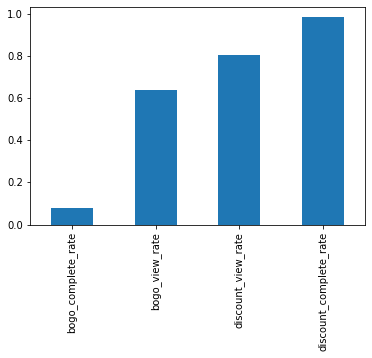

In [346]:
cluster_01[[ 'bogo_complete_rate', 'discount_complete_rate', 'bogo_view_rate',
       'discount_view_rate']].mean().sort_values().plot(kind='bar')

iv. How many offers (on average) customers in this cluster __received__ of each offer type? 

v. How many offers (on average) customers in this cluster __completed__ of each offer type? 

In [347]:
cluster_01[['bogo offer received','discount offer received']].describe()

,bogo offer received,discount offer received
count,1095.000000,1095.000000
mean,1.366210,2.141553
std,1.093503,0.955624
min,0.000000,1.000000
25%,0.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,3.000000
max,5.000000,5.000000


In [348]:
cluster_01[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,1095.000000,1095.000000
mean,0.184475,1.563470
std,0.410929,0.784527
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,2.000000
max,2.000000,5.000000


vi. How many offers (on average) customers in this cluster __viewed__ of each offer type? 

In [160]:
cluster_01[['bogo offer viewed','discount offer viewed']].describe()

,bogo offer viewed,discount offer viewed
count,1758.000000,1758.000000
mean,1.176337,1.631399
std,1.018703,0.814338
min,0.000000,1.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,4.000000,5.000000


vii. Why small fraction of customers in this cluster prefered bogo? 

In [349]:
bogo_cus = cluster_01[(cluster_01['bogo offer completed'] > cluster_01['discount offer completed']) ]
discout_cus = cluster_01[(cluster_01['bogo offer completed'] < cluster_01['discount offer completed']) ]
equal_likely = cluster_01[(cluster_01['bogo offer completed'] == cluster_01['discount offer completed']) ]

In [350]:
bogo_cus

,gender,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed,bogo offer received,bogo offer viewed,bogo offer completed,discount offer received,discount offer viewed,discount offer completed,informational offer received,informational offer viewed,informational offer completed,bogo offer received (offer availed),bogo offer viewed (offer availed),bogo offer completed (offer availed),discount offer received (offer availed),discount offer viewed (offer availed),discount offer completed (offer availed),informational offer received (offer availed),informational offer viewed (offer availed),informational offer completed (offer availed),bogo_5_5_7_offer completed,discount_5_20_10_offer completed,discount_2_10_7_offer completed,discount_2_10_10_offer completed,bogo_10_10_5_offer completed,bogo_5_5_5_offer completed,discount_3_7_7_offer completed,informational_0_0_4_offer completed,bogo_10_10_7_offer completed,informational_0_0_3_offer completed,age_bucket,member_year,member_month,member_days,cus_type,total_transactions,offer_trans_ratio,Cluster,bogo_complete_rate,discount_complete_rate,bogo_view_rate,discount_view_rate
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c0d210398dee4a0895b24444a5fcd1d2,M,45,2018-07-07,33000.0,0.0,5.0,5.0,8.0,3.0,7.656250,61.25,5,5,3,0.6,1.000000,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,"(38.0, 58.0]",2018,7,7,0,8.0,0.375000,1,0.666667,1.0,1.0,1.0
62274260252f4b04962ec2f85295b447,M,67,2016-01-05,56000.0,0.0,5.0,5.0,6.0,3.0,15.658333,93.95,5,5,3,0.6,1.000000,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,"(58.0, 78.0]",2016,1,5,0,6.0,0.500000,1,0.500000,1.0,1.0,1.0
fbd07f6b2ebd48c2b2a7dc96e244deb5,M,34,2014-09-05,36000.0,0.0,5.0,5.0,19.0,3.0,3.171053,60.25,5,5,3,0.6,1.000000,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"(17.9, 38.0]",2014,9,5,0,19.0,0.157895,1,0.500000,1.0,1.0,1.0
883df6ab4b364bbd85c2373430e12c7e,M,29,2014-06-20,65000.0,0.0,5.0,5.0,20.0,3.0,4.002000,80.04,5,5,3,0.6,1.000000,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,"(17.9, 38.0]",2014,6,20,0,20.0,0.150000,1,0.500000,1.0,1.0,1.0
7d30ff83c4c141d79231d53be5101d9d,M,42,2016-09-05,68000.0,0.0,5.0,5.0,4.0,3.0,17.832500,71.33,5,5,3,0.6,1.000000,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,"(38.0, 58.0]",2016,9,5,0,4.0,0.750000,1,0.500000,1.0,1.0,1.0
4442993b339f48d2b8cf3f2af357cfa3,M,28,2018-06-20,68000.0,0.0,5.0,5.0,6.0,3.0,5.650000,33.90,5,5,3,0.6,1.000000,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,"(17.9, 38.0]",2018,6,20,0,6.0,0.500000,1,0.500000,1.0,1.0,1.0
7c56d46290a54a3292077fd06ee66249,M,86,2016-02-20,56000.0,0.0,6.0,6.0,4.0,3.0,10.522500,42.09,6,6,3,0.5,1.000000,4.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(78.0, 98.0]",2016,2,20,0,4.0,0.750000,1,0.500000,1.0,1.0,1.0
0b6c775f84a8435a9083900e1cb43ec9,M,27,2017-11-09,35000.0,0.0,6.0,5.0,20.0,3.0,2.794500,55.89,6,5,3,0.6,0.833333,4.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(17.9, 38.0]",2017,11,9,0,20.0,0.150000,1,0.500000,1.0,1.0,0.5
09c957e5a4ac4c339b25fe08b12cd921,M,46,2018-02-07,32000.0,0.0,5.0,5.0,8.0,3.0,8.743750,69.95,5,5,3,0.6,1.000000,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,"(38.0, 58.0]",2018,2,7,0,8.0,0.375000,1,0.666667,1.0,1.0,1.0


In [351]:
print(str(round((bogo_cus.shape[0]/cluster_01.shape[0])*100))+'% customers preferred bogo in this cluster')
print(str(round((discout_cus.shape[0]/cluster_01.shape[0])*100))+'% customers preferred discout_cus in this cluster')
print(str(round((equal_likely.shape[0]/cluster_01.shape[0])*100))+'% customers who preferred both offer type (equal_likely) in this cluster')

1% customers preferred bogo in this cluster
88% customers preferred discout_cus in this cluster
11% customers who preferred both offer type (equal_likely) in this cluster


In [352]:
bogo_cus[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,9.0,9.0
mean,2.0,1.0
std,0.0,0.0
min,2.0,1.0
25%,2.0,1.0
50%,2.0,1.0
75%,2.0,1.0
max,2.0,1.0


A. Was it because of income? 

In [353]:
bogo_cus['income'].describe()

count        9.000000
mean     49888.888889
std      15727.717924
min      32000.000000
25%      35000.000000
50%      56000.000000
75%      65000.000000
max      68000.000000
Name: income, dtype: float64

In [354]:
discout_cus['income'].describe()

count      967.000000
mean     52769.389866
std      13529.110319
min      30000.000000
25%      41000.000000
50%      53000.000000
75%      64000.000000
max      85000.000000
Name: income, dtype: float64

_Doesn't seems like it is because of income as the difference is negligible_

B. Was it because of age? 

In [355]:
bogo_cus['age'].describe()

count     9.000000
mean     44.888889
std      19.889975
min      27.000000
25%      29.000000
50%      42.000000
75%      46.000000
max      86.000000
Name: age, dtype: float64

In [356]:
discout_cus['age'].describe()

count    967.000000
mean      48.189245
std       17.620757
min       18.000000
25%       34.000000
50%       48.000000
75%       61.000000
max       93.000000
Name: age, dtype: float64

_Doesn't seems like it is because of age as the difference is negligible_

C. How their total transaction amount is different? 

In [357]:
bogo_cus['total spending'].describe()

count     9.000000
mean     63.183333
std      18.408110
min      33.900000
25%      55.890000
50%      61.250000
75%      71.330000
max      93.950000
Name: total spending, dtype: float64

In [358]:
discout_cus['total spending'].describe()

count    967.000000
mean      64.039100
std       52.386646
min        8.210000
25%       30.155000
50%       48.970000
75%       76.510000
max      472.410000
Name: total spending, dtype: float64

_There seems to have noticable difference is between their spending __(bogo customers at 25% quantile have almost double spending amount compared with 25% quantile of discount customers)___

D. Was it because bogo customers received more bogo offers than discount offers? 

In [359]:
bogo_cus[['bogo offer received','discount offer received']].describe()

,bogo offer received,discount offer received
count,9.000000,9.000000
mean,3.777778,1.111111
std,0.440959,0.333333
min,3.000000,1.000000
25%,4.000000,1.000000
50%,4.000000,1.000000
75%,4.000000,1.000000
max,4.000000,2.000000


In [360]:
discout_cus[['bogo offer received','discount offer received']].describe()

,bogo offer received,discount offer received
count,967.000000,967.000000
mean,1.199586,2.234747
std,1.021751,0.953208
min,0.000000,1.000000
25%,0.000000,2.000000
50%,1.000000,2.000000
75%,2.000000,3.000000
max,5.000000,5.000000


In [361]:
bogo_cus[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,9.0,9.0
mean,2.0,1.0
std,0.0,0.0
min,2.0,1.0
25%,2.0,1.0
50%,2.0,1.0
75%,2.0,1.0
max,2.0,1.0


In [362]:
discout_cus[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,967.000000,967.000000
mean,0.066184,1.637022
std,0.248732,0.806030
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,2.000000
max,1.000000,5.000000


In [363]:
bogo_cus[['bogo offer viewed','discount offer viewed']].describe()

,bogo offer viewed,discount offer viewed
count,9.000000,9.0
mean,3.777778,1.0
std,0.440959,0.0
min,3.000000,1.0
25%,4.000000,1.0
50%,4.000000,1.0
75%,4.000000,1.0
max,4.000000,1.0


In [364]:
discout_cus[['bogo offer viewed','discount offer viewed']].describe()

,bogo offer viewed,discount offer viewed
count,967.000000,967.000000
mean,1.015512,1.704240
std,0.942864,0.854541
min,0.000000,1.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,4.000000,5.000000


## Reasoning: 

- Customers in cluster # 01 usually prefer discount offers (78% to be specific) but 5% of the customers prefered bogo. 
- Those who preferred bogo seems to have received more bogo offers than discount offer (roughly 3 bogo offers compared to 1 discount offer) still the discount offer completion rate  is high in those case. If they had received more discount offers they probably prefer discount over bogo. 
- On average customers in this cluster preferred discount by choice because they received and viewed bogo offers (so it eliminate the chance of not seen or recieve bogo offers motivate the otherwise) but didn't complete it. 
- Customers who preferred bogo seems to have high spending compared with discount customers (in one case it was almost double). It is maybe because bogo offers encourage customers to buy more whereas discount reduce the amount of spending. 

2. Cluster # 13 : Prefer bogo over discount. 

In [279]:
cluster_13 = final_df[(final_df['Cluster']==13) & (final_df['invalid']==0)]

i. Is it mostly male cluster? 

In [281]:
cluster_13['gender'].value_counts()

M    538
Name: gender, dtype: int64

ii. What is the income range within this cluster? 

In [282]:
cluster_13['income'].describe()

count       538.000000
mean      62319.702602
std       16977.200790
min       30000.000000
25%       51000.000000
50%       61000.000000
75%       74000.000000
max      106000.000000
Name: income, dtype: float64

ii. What is spending distribution within this cluster? 

In [283]:
cluster_13['total spending'].describe()

count    538.000000
mean     101.720297
std       73.785911
min        5.280000
25%       47.947500
50%       88.740000
75%      134.177500
max      478.920000
Name: total spending, dtype: float64

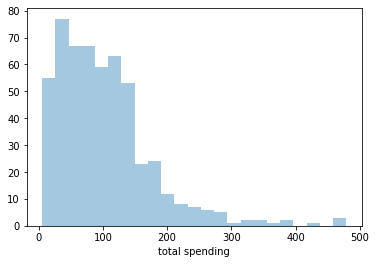

In [285]:
sns.distplot(cluster_13['total spending'], kde=False)

iii. Does customers in this cluster prefer discount because they didn't view bogo offers? 

In [286]:
cluster_13 = cluster_13.assign(bogo_complete_rate = cluster_13['bogo offer completed (offer availed)']/cluster_13['bogo offer viewed (offer availed)'])
cluster_13 = cluster_13.assign(discount_complete_rate= cluster_13['discount offer completed (offer availed)']/cluster_13['discount offer viewed (offer availed)'])

cluster_13 = cluster_13.assign(bogo_view_rate= cluster_13['bogo offer viewed (offer availed)']/cluster_13['bogo offer received (offer availed)'])
cluster_13 = cluster_13.assign(discount_view_rate= cluster_13['discount offer viewed (offer availed)']/cluster_13['discount offer received (offer availed)'])

In [287]:
cluster_13[['bogo_complete_rate', 'discount_complete_rate', 'bogo_view_rate',
       'discount_view_rate']] = cluster_13[['bogo_complete_rate', 'discount_complete_rate', 'bogo_view_rate',
       'discount_view_rate']].fillna(0)

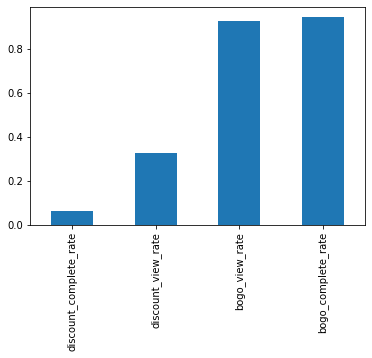

In [288]:
cluster_13[[ 'bogo_complete_rate', 'discount_complete_rate', 'bogo_view_rate',
       'discount_view_rate']].mean().sort_values().plot(kind='bar')

iv. How many offers (on average) customers in this cluster __received__ of each offer type? 

v. How many offers (on average) customers in this cluster __completed__ of each offer type? 

In [289]:
cluster_13[['bogo offer received','discount offer received']].describe()

,bogo offer received,discount offer received
count,538.000000,538.000000
mean,2.115242,0.845725
std,1.066552,0.986119
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,3.000000,2.000000
max,6.000000,4.000000


In [290]:
cluster_13[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,538.000000,538.000000
mean,1.760223,0.135688
std,0.931618,0.363858
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,2.000000,0.000000
max,5.000000,2.000000


vi. How many offers (on average) customers in this cluster __viewed__ of each offer type? 

In [291]:
cluster_13[['bogo offer viewed','discount offer viewed']].describe()

,bogo offer viewed,discount offer viewed
count,538.000000,538.000000
mean,1.927509,0.563197
std,1.032230,0.865597
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,2.000000,1.000000
max,6.000000,4.000000


vii. Why small fraction of customers in this cluster prefered discount? 

In [292]:
bogo_cus = cluster_13[(cluster_13['bogo offer completed'] > cluster_13['discount offer completed']) ]
discout_cus = cluster_13[(cluster_13['bogo offer completed'] < cluster_13['discount offer completed']) ]
equal_likely = cluster_13[(cluster_13['bogo offer completed'] == cluster_13['discount offer completed']) ]

In [293]:
bogo_cus

,gender,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed,bogo offer received,bogo offer viewed,bogo offer completed,discount offer received,discount offer viewed,discount offer completed,informational offer received,informational offer viewed,informational offer completed,bogo offer received (offer availed),bogo offer viewed (offer availed),bogo offer completed (offer availed),discount offer received (offer availed),discount offer viewed (offer availed),discount offer completed (offer availed),informational offer received (offer availed),informational offer viewed (offer availed),informational offer completed (offer availed),bogo_5_5_7_offer completed,discount_5_20_10_offer completed,discount_2_10_7_offer completed,discount_2_10_10_offer completed,bogo_10_10_5_offer completed,bogo_5_5_5_offer completed,discount_3_7_7_offer completed,informational_0_0_4_offer completed,bogo_10_10_7_offer completed,informational_0_0_3_offer completed,age_bucket,member_year,member_month,member_days,cus_type,total_transactions,offer_trans_ratio,Cluster,bogo_complete_rate,discount_complete_rate,bogo_view_rate,discount_view_rate
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
62cf5e10845442329191fc246e7bcea3,M,49,2014-11-13,52000.0,0.0,3.0,2.0,9.0,1.0,16.012222,144.11,3,2,1,0.500000,0.666667,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(38.0, 58.0]",2014,11,13,0,9.0,0.111111,13,1.0,0.0,1.0,0.0
571b739ada3041fb8fbd20f23ce034f7,M,78,2015-11-11,58000.0,0.0,6.0,6.0,10.0,3.0,12.694000,126.94,6,6,3,0.500000,1.000000,3.0,3.0,3.0,0.0,0.0,0.0,3.0,3.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,"(58.0, 78.0]",2015,11,11,0,10.0,0.300000,13,1.0,0.0,1.0,0.0
81e9ad5fa55a4884b65e01a5db8f1b4e,M,79,2016-06-27,67000.0,0.0,4.0,3.0,18.0,3.0,17.612778,317.03,4,3,3,1.000000,0.750000,3.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,"(78.0, 98.0]",2016,6,27,0,18.0,0.166667,13,1.0,0.0,1.0,0.0
37a97f6e09784a07bbb67bc6539f1a00,M,55,2017-12-03,66000.0,0.0,5.0,3.0,19.0,2.0,14.327895,272.23,5,3,2,0.666667,0.600000,2.0,2.0,2.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,"(38.0, 58.0]",2017,12,3,0,19.0,0.105263,13,1.0,0.0,1.0,0.0
dbca75f289544e09836322ba2e104854,M,49,2018-06-02,59000.0,0.0,3.0,2.0,6.0,1.0,6.376667,38.26,3,2,1,0.500000,0.666667,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"(38.0, 58.0]",2018,6,2,0,6.0,0.166667,13,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8d80970192fa496f99d6b45c470a4b60,M,30,2017-10-18,62000.0,0.0,4.0,4.0,9.0,1.0,4.466667,40.20,4,4,1,0.250000,1.000000,2.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(17.9, 38.0]",2017,10,18,0,9.0,0.111111,13,0.5,0.0,1.0,0.0
d1c4500ace2e45e9a45d3cd2fccac8d8,M,87,2014-09-20,59000.0,0.0,5.0,2.0,12.0,1.0,3.290833,39.49,5,2,1,0.500000,0.400000,2.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"(78.0, 98.0]",2014,9,20,0,12.0,0.083333,13,1.0,0.0,0.5,0.0
b3a1272bc9904337b331bf348c3e8c17,M,66,2018-01-01,47000.0,0.0,3.0,2.0,14.0,1.0,4.142857,58.00,3,2,1,0.500000,0.666667,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(58.0, 78.0]",2018,1,1,0,14.0,0.071429,13,1.0,0.0,1.0,0.0


In [294]:
print(str(round((bogo_cus.shape[0]/cluster_13.shape[0])*100))+'% customers preferred bogo in this cluster')
print(str(round((discout_cus.shape[0]/cluster_13.shape[0])*100))+'% customers preferred discout_cus in this cluster')
print(str(round((equal_likely.shape[0]/cluster_13.shape[0])*100))+'% customers who preferred both offer type (equal_likely) in this cluster')

91% customers preferred bogo in this cluster
1% customers preferred discout_cus in this cluster
8% customers who preferred both offer type (equal_likely) in this cluster


In [295]:
discout_cus[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,4.0,4.0
mean,1.0,2.0
std,0.0,0.0
min,1.0,2.0
25%,1.0,2.0
50%,1.0,2.0
75%,1.0,2.0
max,1.0,2.0


A. Was it because of income? 

In [296]:
bogo_cus['income'].describe()

count       492.000000
mean      62674.796748
std       17241.425005
min       30000.000000
25%       51000.000000
50%       62000.000000
75%       75000.000000
max      106000.000000
Name: income, dtype: float64

In [297]:
discout_cus['income'].describe()

count        4.000000
mean     62250.000000
std       2872.281323
min      59000.000000
25%      61250.000000
50%      62000.000000
75%      63000.000000
max      66000.000000
Name: income, dtype: float64

Can't compare 4 observations with 500 observations. 

B. Was it because of age? 

_Doesn't seems like it is because of income as the difference is negligible_

In [298]:
bogo_cus['age'].describe()

count    492.000000
mean      53.481707
std       15.451576
min       18.000000
25%       43.000000
50%       53.000000
75%       64.000000
max       95.000000
Name: age, dtype: float64

In [299]:
discout_cus['age'].describe()

count     4.000000
mean     53.250000
std      20.678088
min      34.000000
25%      37.000000
50%      51.000000
75%      67.250000
max      77.000000
Name: age, dtype: float64

Can't compare 4 observations with 500 observations. 

Can't compare 4 observations with 500 observations. 

C. How their total transaction amount is different? 

In [300]:
bogo_cus['total spending'].describe()

count    492.000000
mean     104.631321
std       75.502091
min        5.280000
25%       51.260000
50%       90.740000
75%      139.345000
max      478.920000
Name: total spending, dtype: float64

_Doesn't seems like it is because of age as the difference is negligible_

In [301]:
discout_cus['total spending'].describe()

count     4.000000
mean     47.637500
std      19.382421
min      32.130000
25%      32.392500
50%      42.895000
75%      58.140000
max      72.630000
Name: total spending, dtype: float64

Can't compare 4 observations with 500 observations. 

D. Was it because discount customers received more discount offers than bogo offers? 

In [302]:
bogo_cus[['bogo offer received','discount offer received']].describe()

,bogo offer received,discount offer received
count,492.000000,492.000000
mean,2.199187,0.701220
std,1.068413,0.878667
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,1.000000
max,6.000000,3.000000


In [303]:
discout_cus[['bogo offer received','discount offer received']].describe()

,bogo offer received,discount offer received
count,4.0,4.0
mean,1.0,4.0
std,0.0,0.0
min,1.0,4.0
25%,1.0,4.0
50%,1.0,4.0
75%,1.0,4.0
max,1.0,4.0


In [304]:
bogo_cus[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,492.000000,492.000000
mean,1.831301,0.046748
std,0.943407,0.211313
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,2.000000,0.000000
max,5.000000,1.000000


In [209]:
profile_main_centroid

,bogo_complete_rate,discount_complete_rate,income,total spending,gender_F,gender_M,gender_O,age
0,0.949335,1.010647,60401.914532,152.875200,-8.493206e-15,1.000000e+00,3.469447e-18,54.336661
1,0.071720,0.975929,53246.871445,81.401132,3.330669e-15,1.000000e+00,7.632783e-17,48.939135
2,0.110322,0.434451,97797.830375,123.650089,1.000000e+00,-4.440892e-16,-3.989864e-17,64.959566
3,0.511242,0.549764,63287.735849,124.323302,-1.665335e-15,-6.661338e-16,1.000000e+00,54.400943
4,0.068298,0.172010,65180.937066,18.791576,3.552714e-15,1.000000e+00,-7.632783e-17,117.072744
5,0.068822,0.069238,74692.138134,52.518766,4.496403e-15,1.000000e+00,2.428613e-17,53.947098
6,0.651455,0.607143,78027.777778,813.573492,5.000000e-01,5.000000e-01,-3.122502e-17,56.956349
7,0.940310,0.073043,72863.255034,142.551074,1.000000e+00,-3.552714e-15,-6.418477e-17,57.968960
8,0.109343,0.988963,58534.924845,120.101247,1.000000e+00,2.886580e-15,1.214306e-17,53.938992
9,0.552896,0.818105,95622.554661,190.656766,-1.387779e-15,1.000000e+00,-2.775558e-17,63.004603


In [305]:
discout_cus[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,4.0,4.0
mean,1.0,2.0
std,0.0,0.0
min,1.0,2.0
25%,1.0,2.0
50%,1.0,2.0
75%,1.0,2.0
max,1.0,2.0


In [306]:
bogo_cus[['bogo offer viewed','discount offer viewed']].describe()

,bogo offer viewed,discount offer viewed
count,492.000000,492.000000
mean,2.010163,0.406504
std,1.039886,0.703062
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,1.000000
max,6.000000,3.000000


In [307]:
discout_cus[['bogo offer viewed','discount offer viewed']].describe()

,bogo offer viewed,discount offer viewed
count,4.0,4.0
mean,1.0,4.0
std,0.0,0.0
min,1.0,4.0
25%,1.0,4.0
50%,1.0,4.0
75%,1.0,4.0
max,1.0,4.0


## Reasoning: 

- Those who prefer bogo (91%) they received more bogo offers (roughly 2 bogo offers compared to 1 discount offer) but for discount offers (they received and viewed) complete rate is bit low (which may depict their concious choice).
- Those who prefer discount completed 2 out of 4 discount offer whereas completed 1 bogo out of 1 . This indicate if this group had been sent more bogo offer they probably choose it over discount (right now they were send more discount offers than bogo (4 discount offer compared with 1 bogo offer).
- In fact there are only 4 observations (who pefer discount over bogo) so results based on comparision may not be significant. 

---------------------

In [415]:
cluster_04 = final_df[(final_df['Cluster']==4) & (final_df['invalid']==0)]

In [416]:
cluster_04

,gender,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed,bogo offer received,bogo offer viewed,bogo offer completed,discount offer received,discount offer viewed,discount offer completed,informational offer received,informational offer viewed,informational offer completed,bogo offer received (offer availed),bogo offer viewed (offer availed),bogo offer completed (offer availed),discount offer received (offer availed),discount offer viewed (offer availed),discount offer completed (offer availed),informational offer received (offer availed),informational offer viewed (offer availed),informational offer completed (offer availed),bogo_5_5_7_offer completed,discount_5_20_10_offer completed,discount_2_10_7_offer completed,discount_2_10_10_offer completed,bogo_10_10_5_offer completed,bogo_5_5_5_offer completed,discount_3_7_7_offer completed,informational_0_0_4_offer completed,bogo_10_10_7_offer completed,informational_0_0_3_offer completed,age_bucket,member_year,member_month,member_days,cus_type,total_transactions,offer_trans_ratio,Cluster
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,M,118,2017-02-12,65404.991568,0.0,5.0,5.0,9.0,2.0,2.266667,20.40,5,5,2,0.400000,1.00,0.0,0.0,0.0,5.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"(98.0, 118.0]",2017,2,12,0,9.0,0.222222,4
38fe809add3b4fcf9315a9694bb96ff5,M,118,2018-07-12,65404.991568,0.0,2.0,2.0,6.0,0.0,2.383333,14.30,2,2,0,0.000000,1.00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(98.0, 118.0]",2018,7,12,0,6.0,0.000000,4
a03223e636434f42ac4c3df47e8bac43,M,118,2017-08-04,65404.991568,0.0,5.0,3.0,3.0,0.0,1.550000,4.65,5,3,0,0.000000,0.60,0.0,0.0,0.0,3.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(98.0, 118.0]",2017,8,4,0,3.0,0.000000,4
8ec6ce2a7e7949b1bf142def7d0e0586,M,118,2017-09-25,65404.991568,0.0,5.0,5.0,0.0,0.0,13.680266,0.00,5,5,0,0.000000,1.00,1.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(98.0, 118.0]",2017,9,25,0,NaN,NaN,4
68617ca6246f4fbc85e91a2a49552598,M,118,2017-10-02,65404.991568,0.0,5.0,4.0,2.0,0.0,0.120000,0.24,5,4,0,0.000000,0.80,3.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(98.0, 118.0]",2017,10,2,0,2.0,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5c686d09ca4d475a8f750f2ba07e0440,M,118,2016-09-01,65404.991568,0.0,5.0,3.0,7.0,1.0,3.607143,25.25,5,3,1,0.333333,0.60,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"(98.0, 118.0]",2016,9,1,0,7.0,0.142857,4
d9ca82f550ac4ee58b6299cf1e5c824a,M,118,2016-04-15,65404.991568,0.0,4.0,3.0,20.0,2.0,1.551000,31.02,4,3,2,0.666667,0.75,1.0,0.0,0.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"(98.0, 118.0]",2016,4,15,0,20.0,0.100000,4
ca45ee1883624304bac1e4c8a114f045,M,118,2018-03-05,65404.991568,0.0,5.0,5.0,2.0,0.0,0.380000,0.76,5,5,0,0.000000,1.00,1.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(98.0, 118.0]",2018,3,5,0,2.0,0.000000,4


i. Is it mostly male cluster? 

In [417]:
cluster_04['gender'].value_counts()

M    2227
Name: gender, dtype: int64

ii. What is the income range within this cluster? 

In [418]:
cluster_04['income'].describe()

count     2227.000000
mean     65180.937066
std       2554.106598
min      31000.000000
25%      65404.991568
50%      65404.991568
75%      65404.991568
max      90000.000000
Name: income, dtype: float64

ii. What is spending distribution within this cluster? 

In [419]:
cluster_04['total spending'].describe()

count    2227.000000
mean       18.791576
std        19.537747
min         0.000000
25%         7.050000
50%        14.780000
75%        24.000000
max       165.680000
Name: total spending, dtype: float64

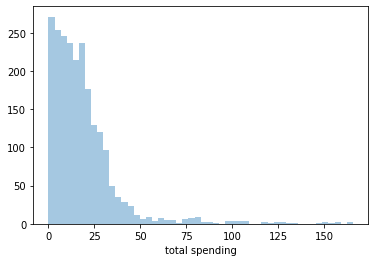

In [420]:
sns.distplot(cluster_04['total spending'], kde=False)

In [421]:
cluster_04[cluster_04['total spending']==0].shape[0]

95

iii. Does customers in this cluster prefer discount because they didn't view bogo offers? 

In [422]:
cluster_04 = cluster_04.assign(bogo_complete_rate = cluster_04['bogo offer completed (offer availed)']/cluster_04['bogo offer viewed (offer availed)'])
cluster_04 = cluster_04.assign(discount_complete_rate= cluster_04['discount offer completed (offer availed)']/cluster_04['discount offer viewed (offer availed)'])

cluster_04 = cluster_04.assign(bogo_view_rate= cluster_04['bogo offer viewed (offer availed)']/cluster_04['bogo offer received (offer availed)'])
cluster_04 = cluster_04.assign(discount_view_rate= cluster_04['discount offer viewed (offer availed)']/cluster_04['discount offer received (offer availed)'])

In [423]:
cluster_04[['bogo_complete_rate', 'discount_complete_rate', 'bogo_view_rate',
       'discount_view_rate']] = cluster_04[['bogo_complete_rate', 'discount_complete_rate', 'bogo_view_rate',
       'discount_view_rate']].fillna(0)

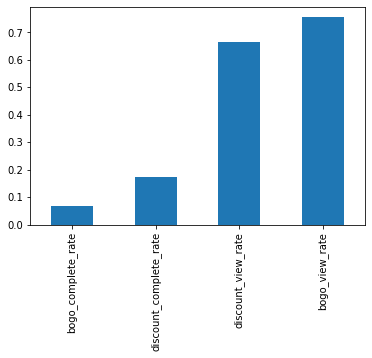

In [424]:
cluster_04[[ 'bogo_complete_rate', 'discount_complete_rate', 'bogo_view_rate',
       'discount_view_rate']].mean().sort_values().plot(kind='bar')

iv. How many offers (on average) customers in this cluster __received__ of each offer type? 

v. How many offers (on average) customers in this cluster __completed__ of each offer type? 

In [425]:
cluster_04[['bogo offer received','discount offer received']].describe()

,bogo offer received,discount offer received
count,2227.000000,2227.000000
mean,1.818590,1.777728
std,1.152502,1.141588
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,6.000000,6.000000


In [426]:
cluster_04[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,2227.000000,2227.000000
mean,0.180063,0.323305
std,0.458911,0.616930
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,4.000000,4.000000


vi. How many offers (on average) customers in this cluster __viewed__ of each offer type? 

In [427]:
cluster_04[['bogo offer viewed','discount offer viewed']].describe()

,bogo offer viewed,discount offer viewed
count,2227.000000,2227.000000
mean,1.562191,1.362371
std,1.100546,1.078785
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,6.000000,6.000000


vii. Why small fraction of customers in this cluster prefered bogo? 

In [428]:
bogo_cus = cluster_04[(cluster_04['bogo offer completed'] > cluster_04['discount offer completed']) ]
discout_cus = cluster_04[(cluster_04['bogo offer completed'] < cluster_04['discount offer completed']) ]
equal_likely = cluster_04[(cluster_04['bogo offer completed'] == cluster_04['discount offer completed']) ]

In [429]:
print(str(round((bogo_cus.shape[0]/cluster_04.shape[0])*100))+'% customers preferred bogo in this cluster')
print(str(round((discout_cus.shape[0]/cluster_04.shape[0])*100))+'% customers preferred discout_cus in this cluster')
print(str(round((equal_likely.shape[0]/cluster_04.shape[0])*100))+'% customers who preferred both offer type (equal_likely) in this cluster')

11% customers preferred bogo in this cluster
22% customers preferred discout_cus in this cluster
68% customers who preferred both offer type (equal_likely) in this cluster


In [430]:
bogo_cus[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,237.000000,237.000000
mean,1.240506,0.042194
std,0.533977,0.201457
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,4.000000,1.000000


A. Was it because of income? 

In [431]:
bogo_cus['income'].describe()

count      237.000000
mean     65046.131165
std       3023.725231
min      33000.000000
25%      65404.991568
50%      65404.991568
75%      65404.991568
max      76000.000000
Name: income, dtype: float64

In [432]:
discout_cus['income'].describe()

count      481.000000
mean     65519.576066
std       2507.594304
min      48000.000000
25%      65404.991568
50%      65404.991568
75%      65404.991568
max      90000.000000
Name: income, dtype: float64

_Doesn't seems like it is because of income as the difference is negligible_

B. Was it because of age? 

In [433]:
bogo_cus['age'].describe()

count    237.000000
mean     116.827004
std        5.625271
min       86.000000
25%      118.000000
50%      118.000000
75%      118.000000
max      118.000000
Name: age, dtype: float64

In [434]:
discout_cus['age'].describe()

count    481.000000
mean     116.977131
std        5.402690
min       82.000000
25%      118.000000
50%      118.000000
75%      118.000000
max      118.000000
Name: age, dtype: float64

_Doesn't seems like it is because of age as the difference is negligible_

C. How their total transaction amount is different? 

In [435]:
bogo_cus['total spending'].describe()

count    237.000000
mean      28.712194
std       21.796971
min        5.460000
25%       17.720000
50%       22.360000
75%       30.550000
max      158.380000
Name: total spending, dtype: float64

In [436]:
discout_cus['total spending'].describe()

count    481.000000
mean      33.399917
std       25.307140
min        7.670000
25%       19.460000
50%       26.660000
75%       35.170000
max      165.680000
Name: total spending, dtype: float64

There is a difference, customer with discount spending a bit more than bogo customers. 

D. Was it because bogo customers received more bogo offers than discount offers? 

In [437]:
bogo_cus[['bogo offer received','discount offer received']].describe()

,bogo offer received,discount offer received
count,237.000000,237.000000
mean,2.481013,1.215190
std,1.031628,0.978639
min,1.000000,0.000000
25%,2.000000,0.000000
50%,2.000000,1.000000
75%,3.000000,2.000000
max,5.000000,5.000000


In [438]:
discout_cus[['bogo offer received','discount offer received']].describe()

,bogo offer received,discount offer received
count,481.000000,481.000000
mean,1.374220,2.465696
std,0.936127,1.001753
min,0.000000,1.000000
25%,1.000000,2.000000
50%,1.000000,2.000000
75%,2.000000,3.000000
max,4.000000,6.000000


In [439]:
bogo_cus[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,237.000000,237.000000
mean,1.240506,0.042194
std,0.533977,0.201457
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,4.000000,1.000000


In [440]:
discout_cus[['bogo offer completed','discount offer completed']].describe()

,bogo offer completed,discount offer completed
count,481.000000,481.000000
mean,0.058212,1.311850
std,0.243114,0.583135
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,2.000000
max,2.000000,4.000000


In [441]:
bogo_cus[['bogo offer viewed','discount offer viewed']].describe()

,bogo offer viewed,discount offer viewed
count,237.000000,237.000000
mean,2.109705,0.793249
std,0.963635,0.865705
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,3.000000,1.000000
max,5.000000,3.000000


In [442]:
discout_cus[['bogo offer viewed','discount offer viewed']].describe()

,bogo offer viewed,discount offer viewed
count,481.000000,481.000000
mean,1.172557,1.962578
std,0.885859,0.988819
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,2.000000
max,4.000000,6.000000


## Reasoning: 

- It seems like there are two group within this cluster. 

    - First who prefer bogo more than discount, though they receive view discount offer but don't complete it. 
    
    - Second who prefer discount more than bogo, though they receive and view but don't complete it. 

Can't compare 4 observations with 500 observations. 

# Remarks: 

In [ ]:
1. Cluster #01 

In [87]:
cluser2 = final_df[final_df['Cluster']==2]

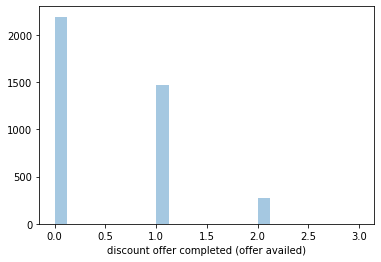

In [245]:
sns.distplot(cluser2['discount offer completed (offer availed)'], kde=False)

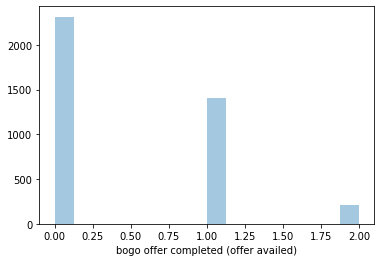

In [246]:
sns.distplot(cluser2['bogo offer completed (offer availed)'],kde=False)

0               bogo_5_5_7
1         discount_5_20_10
2          discount_2_10_7
3         discount_2_10_10
4             bogo_10_10_5
                ...       
306529                 NaN
306530                 NaN
306531                 NaN
306532                 NaN
306533                 NaN
Name: promotion, Length: 297057, dtype: object

In [399]:
def compare_features(df, features, xlabel = 'cluster', ylabel = 'std value', figsize = (10,8)):
    """ This function is just to plot selected features"""
    n_cols = len(features)
    rows = n_cols//2 + (n_cols % 2 >0)
    
    f, axs = plt.subplots(rows,2, figsize=figsize)
    axs = axs.flatten()

    for i in range(n_cols):
        sns.barplot(df.index,features[i], data= df, ax= axs[i])
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(ylabel)
        axs[i].set_title('Feature : ' + features[i])
        
    plt.tight_layout()

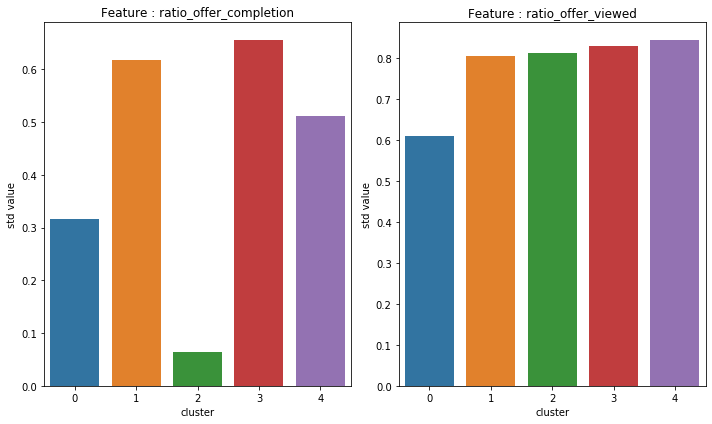

In [138]:
""" Visualize completed rate for each offer and cluster"""

features = [
    'ratio_offer_completion',
    'ratio_offer_viewed']

compare_features(profile_main_centroid, features, figsize=(10,6))

- Scatterplots for different clusters. 

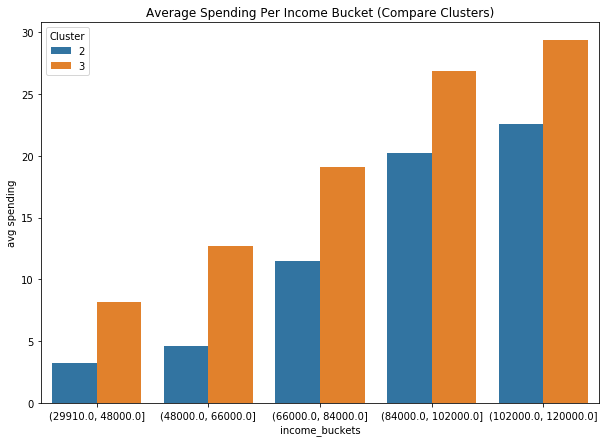

In [111]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x ='income_buckets',y ='avg spending', hue='Cluster',data=temp ,ci=False)
ax.set_title('Average Spending Per Income Bucket (Compare Clusters)')
plt.show()

<b style="color:red;"> Observation: </b>
Average Spending of Cluster 3 is high is all income buckets compared to cluster 2 

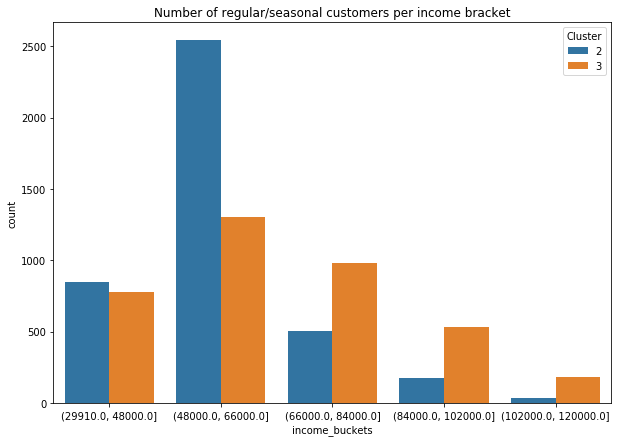

In [113]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x ='income_buckets', hue='Cluster',data=temp )
ax.set_title('Number of regular/seasonal customers per income bracket')
plt.show()

<b style="color:red;"> Observation: </b>
Cluster 2 contains regular customers and it is evident that two income buckets (from left) have high no of regular customer (often more than seasonal customers) and this number decline afterwards in rest of the income buckets. 

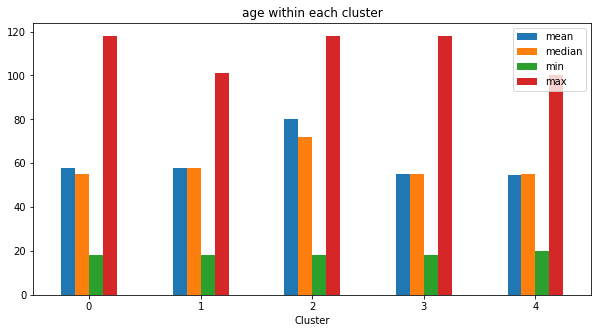

In [135]:
functions = ['mean','median','min','max']
agg = final_df.groupby(by=['Cluster'])['age'].agg(functions).plot(kind='bar',figsize=(10,5)
                                                                                ,rot=0,
                                                                                title='age within each cluster')


<b style="color:red;"> Observation: </b>
Not much difference between cluster w.r.t. age. 

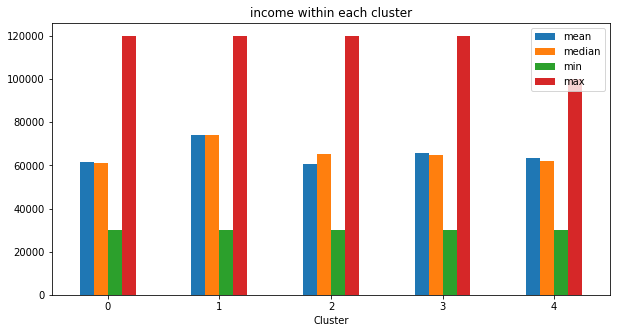

In [136]:
functions = ['mean','median','min','max']
agg = final_df.groupby(by=['Cluster'])['income'].agg(functions).plot(kind='bar',figsize=(10,5)
                                                                                ,rot=0,
                                                                                title='income within each cluster')


<b style="color:red;"> Observation: </b>
Not much difference between cluster w.r.t. income. 

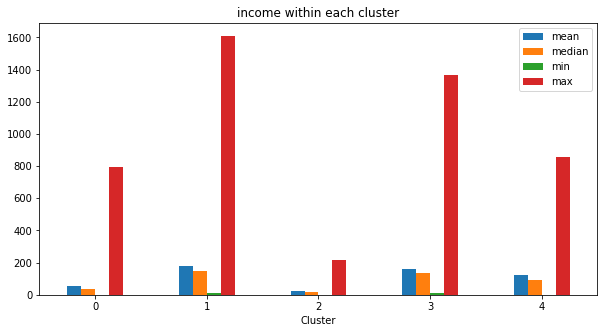

In [137]:
functions = ['mean','median','min','max']
agg = final_df.groupby(by=['Cluster'])['total spending'].agg(functions).plot(kind='bar',figsize=(10,5)
                                                                                ,rot=0,
                                                                                title='income within each cluster')


<b style="color:red;"> Observation: </b>
total spending of C0 and C2 is low compared with C1,C3 and C4. 

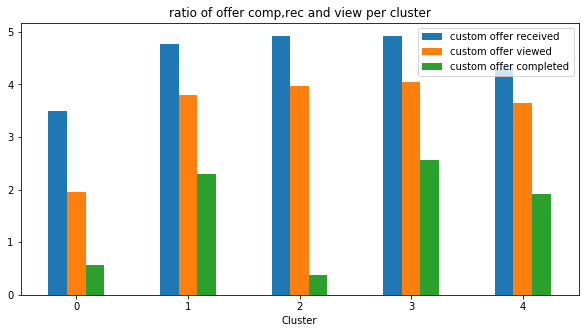

In [149]:
functions = ['mean']#,'median','min','max']
agg = final_df.groupby(by=['Cluster'])['custom offer received','custom offer viewed','custom offer completed'].mean().plot(kind='bar',figsize=(10,5),rot=0,title='ratio of offer comp,rec and view per cluster')
plt.show()

<b style="color:red;"> Observation: </b>
offer comp ratio in C0 and C2 is low compared with C1,C3 and C4. Perhaps if ppl in C0 viewed more offers they had completed more offer (as this C0 has bit high comp rate compared to C1)

In [151]:
final_df

,gender,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed,Cluster
68be06ca386d4c31939f3a4f0e3dd783,M,118,20170212,65404.991568,0.0,5.0,5.0,9.0,2.0,2.266667,20.40,5,5,2,0.400000,1.000000,2
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.000000,1.0,2.0,0.0,3.0,1.0,25.670000,77.01,2,0,0,0.400000,0.000000,0
38fe809add3b4fcf9315a9694bb96ff5,M,118,20180712,65404.991568,0.0,2.0,2.0,6.0,0.0,2.383333,14.30,2,2,0,0.000000,1.000000,0
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.000000,1.0,4.0,4.0,7.0,3.0,22.752857,159.27,4,4,2,0.500000,1.000000,1
a03223e636434f42ac4c3df47e8bac43,M,118,20170804,65404.991568,0.0,5.0,3.0,3.0,0.0,1.550000,4.65,5,3,0,0.000000,0.600000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,20180604,54000.000000,0.0,3.0,3.0,7.0,0.0,2.861429,20.03,3,3,0,0.000000,1.000000,0
2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.000000,1.0,3.0,1.0,7.0,1.0,3.710000,25.97,3,1,0,0.000000,0.333333,0
01d26f638c274aa0b965d24cefe3183f,M,49,20170126,73000.000000,0.0,3.0,1.0,8.0,0.0,4.967500,39.74,3,1,0,0.000000,0.333333,0
9dc1421481194dcd9400aec7c9ae6366,F,83,20160307,50000.000000,2.0,3.0,3.0,14.0,3.0,13.547857,189.67,3,3,1,0.333333,1.000000,1


------------------

---------------

In [95]:
trans_clean_dt[(trans_clean_dt['person']=='f9ee0b3499324d7c995278b18abb33ad') & (trans_clean_dt['event']=='offer viewed')]

,person,event,time,offer,amount,reward,difficulty,duration,offer_type,web,email,mobile,social,promotion,gender,age,became_member_on,income,invalid
18580,f9ee0b3499324d7c995278b18abb33ad,offer viewed,12,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,discount_3_7_7,F,59,2017-08-21,95000.0,0
72715,f9ee0b3499324d7c995278b18abb33ad,offer viewed,180,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,discount_3_7_7,F,59,2017-08-21,95000.0,0
130712,f9ee0b3499324d7c995278b18abb33ad,offer viewed,348,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_5_5_7,F,59,2017-08-21,95000.0,0


In [96]:
trans_clean_dt[(trans_clean_dt['person']=='f9ee0b3499324d7c995278b18abb33ad') & (trans_clean_dt['event']=='offer completed')]

,person,event,time,offer,amount,reward,difficulty,duration,offer_type,web,email,mobile,social,promotion,gender,age,became_member_on,income,invalid
24584,f9ee0b3499324d7c995278b18abb33ad,offer completed,30,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,discount_3_7_7,F,59,2017-08-21,95000.0,0
87514,f9ee0b3499324d7c995278b18abb33ad,offer completed,222,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,discount_3_7_7,F,59,2017-08-21,95000.0,0
135730,f9ee0b3499324d7c995278b18abb33ad,offer completed,360,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_5_5_7,F,59,2017-08-21,95000.0,0
177853,f9ee0b3499324d7c995278b18abb33ad,offer completed,432,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_5_5_7,F,59,2017-08-21,95000.0,0


In [93]:
final_df[final_df.index=='f9ee0b3499324d7c995278b18abb33ad'][['bogo offer received (offer availed)',
       'bogo offer viewed (offer availed)',
       'bogo offer completed (offer availed)']]

,bogo offer received (offer availed),bogo offer viewed (offer availed),bogo offer completed (offer availed)
f9ee0b3499324d7c995278b18abb33ad,3.0,1.0,2.0


In [71]:
final_df['bogo offer completed (offer availed)'].max()

Index(['gender', 'age', 'became_member_on', 'income', 'invalid',
       'offer received', 'offer viewed', 'transaction', 'offer completed',
       'avg spending', 'total spending', 'custom offer received',
       'custom offer viewed', 'custom offer completed',
       'ratio_offer_completion', 'ratio_offer_viewed', 'bogo offer received',
       'bogo offer viewed', 'bogo offer completed', 'discount offer received',
       'discount offer viewed', 'discount offer completed',
       'informational offer received', 'informational offer viewed',
       'informational offer completed', 'bogo offer received (offer availed)',
       'bogo offer viewed (offer availed)',
       'bogo offer completed (offer availed)',
       'discount offer received (offer availed)',
       'discount offer viewed (offer availed)',
       'discount offer completed (offer availed)',
       'informational offer received (offer availed)',
       'informational offer viewed (offer availed)',
       'informational off

In [102]:
final_df['ratio_offer_completion']

2.0